# Zillow Clustering Project

#### Anna Vu (June 2021)



<br>

## Agenda

 - Executive Summary
 - Imports and Data Wrangling
 - Data Exploration
 - Modeling
 - Conclusion and Next Steps

<br>

## Executive Summary

Goals: Build a new regression model to predict logerror (log(Zestimate) - log(SalePrice)), and use clustering to see if we can find groups of similar observations to generate new features to be fed into our supervised model.

Best Features: Property age, number of bathrooms and bedrooms, dollar per square foot, total square feet.

Takeaways: N/A

<br>

In [1]:
#imports
import os
import pandas as pd
from env import username, host, password 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from wrangle import get_zillow_data, prepare_zillow, train_validate_test_split, train_validate_test, impute_nulls, split_X_y, standard_scale_data, get_object_cols, get_numeric_X_cols  
from explore import explore_univariate, create_cluster, create_scatter_plot, get_zillow_heatmap

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score

## Data Wrangling

Acquire 2017 Zillow data from SQL, and turn it into a .csv for quicker use

In [2]:
#get our data, turn into .csv, and check shape
df = get_zillow_data()
df.shape

(77575, 68)

Takeaways:
 - Lots of missing values
 - Some columns have inaccurate content?
 - Let's just clean it up for now, and we'll decide what we want to explore on later

<br>

Prepare our data for mostly-ready use. We're going to rename columns, make dummies, create new features, drop outliers, and drop columns and rows with more than 50% missing values.

In [3]:
df = prepare_zillow(df)

We are going to split our data into train, validate, and test sets. Impute where we can, and drop the rest of the nulls.

In [4]:
#split into train, validate, test. Our target is logerror
train, validate, test = train_validate_test_split(df, 'logerror', seed=1349)

In [5]:
#return our train, validate, and test sets with calculatedbathnbr, fullbathcnt, regionidcity, regionidzip,censustractandblock
#imputed with most frequent values
train, validate, test = impute_nulls(train, validate, test, strategy='most_frequent', 
                        col_list=['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'censustractandblock'])

In [6]:
#return our train, validate, and test sets with finishedsquarefeet12, lotsizesquarefeet, structuretaxvaluedollarcnt, 
#tax_value, land tax value dollar count, and tax amount imputed with the column's median value. 
train, validate, test = impute_nulls(train, validate, test, strategy='median', 
                        col_list=['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 
                                  'tax_value', 'landtaxvaluedollarcnt', 'tax_amount'])

In [7]:
#drop rows with remaining nulls from all of our split sets
train = train.dropna()
validate = validate.dropna()
test = test.dropna()

In [8]:
#assuring there are no more nulls and we can almost get to work
train.isna().sum().sum() + validate.isna().sum().sum() + test.isna().sum().sum()

0

In [9]:
#total rows and columns that are left to work with 
print (f' We now have {train.shape[0] + validate.shape[0] + test.shape[0]} rows, and {train.shape[1]} columns after preparing')

 We now have 49645 rows, and 47 columns after preparing


In [10]:
#split new train, validate, and test into X_train, y_train, X_validate, y_validate, X_test, y_test with logerror as our target
X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train, validate, test, 'logerror')

In [11]:
#get object columns, and numeric columns so we can scale our data
obj_cols = get_object_cols(X_train)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [12]:
#scale our X_train, X_validate, and X_test with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = standard_scale_data(X_train[num_cols],X_validate[num_cols],X_test[num_cols])

Takeaways:
 - Our data is now clean, and split. 
 - We dropped any rows and columns with more than 50% missing values
 - Dropped, filled, or imputed for remaining missing values
 - We went from 77,575 rows to 49,645 rows.
 - We had 68 columns, now 47.

<br>

## Explore

Hypothesis List
 - - -  - - - - -

1.) Log error is affected by square footage, number of bedrooms and bathrooms.

2.) Log error is affected by property age

3.) Log error is affected by location

4.) Log error is affected by price per sq ft.

5.) Log error is affected by combinations of internal property features and combinations of locational features. 

#### Univariate Exploration

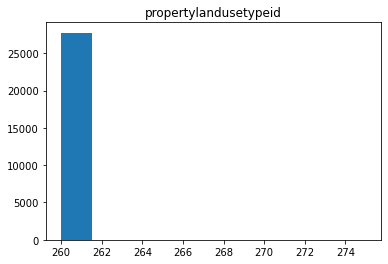

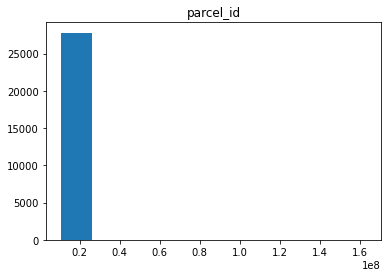

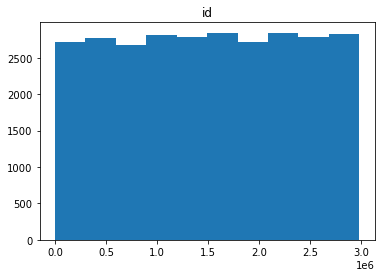

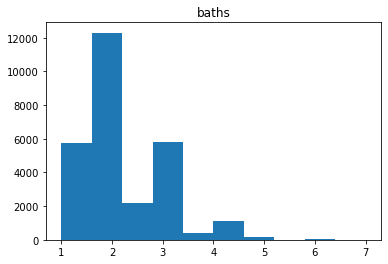

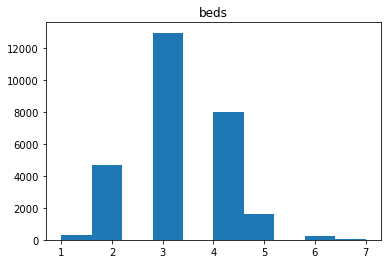

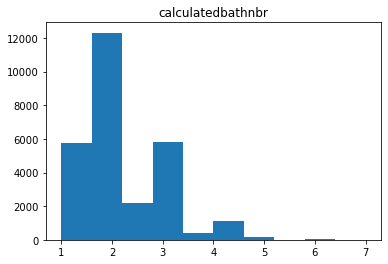

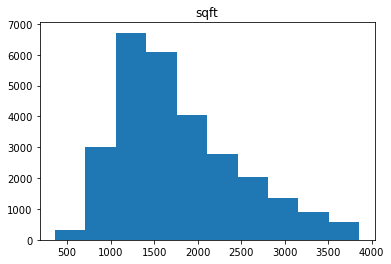

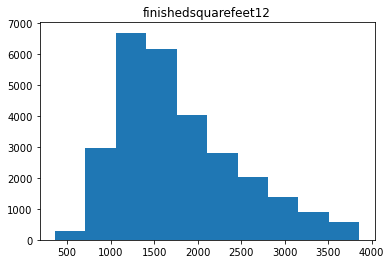

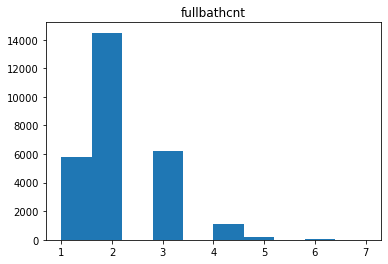

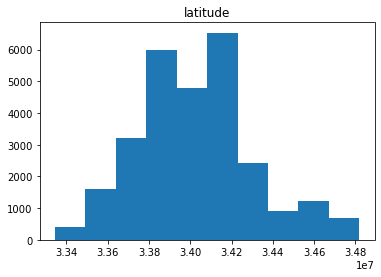

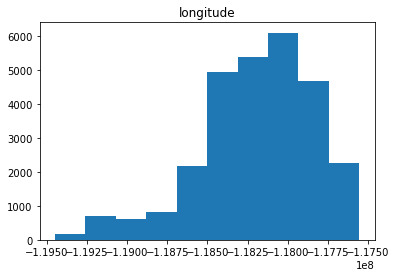

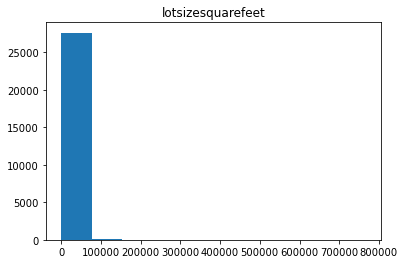

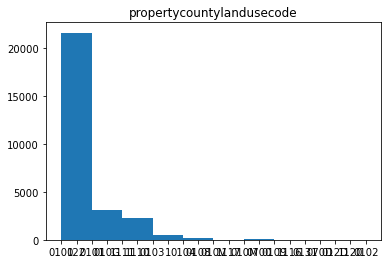

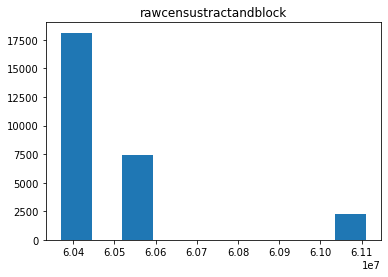

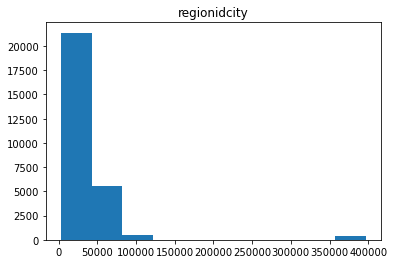

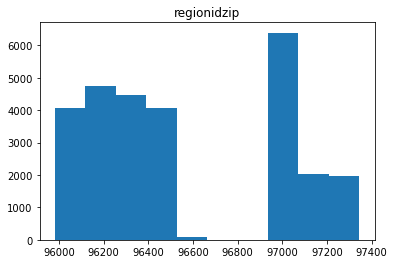

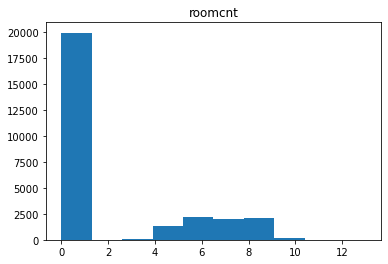

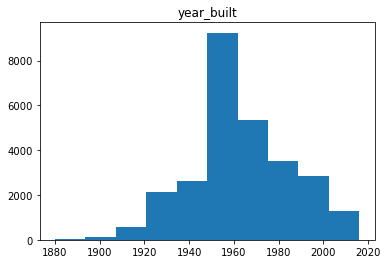

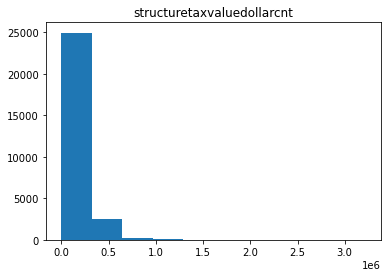

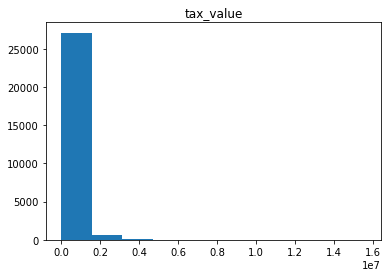

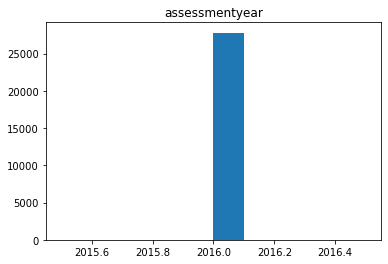

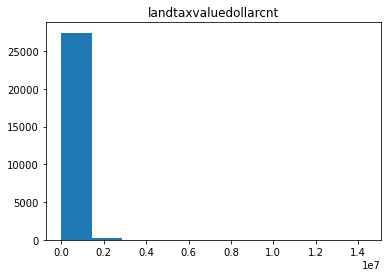

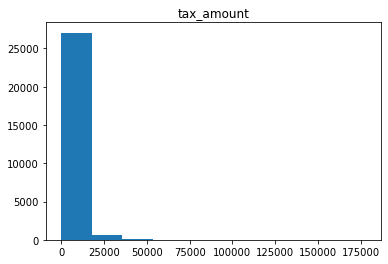

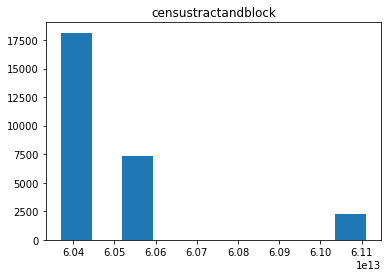

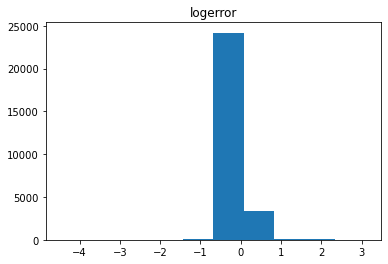

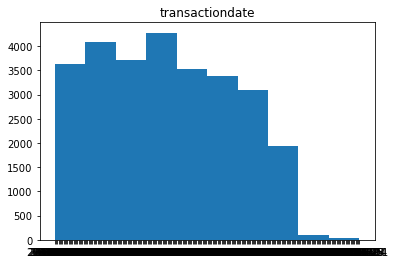

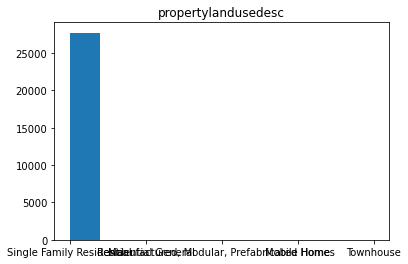

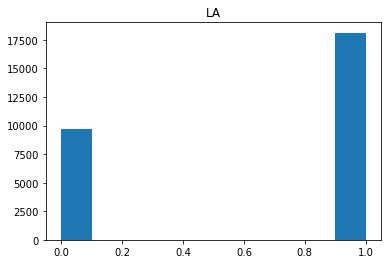

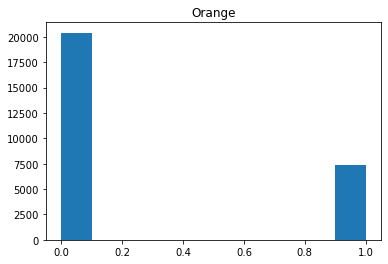

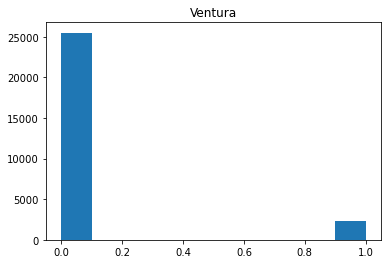

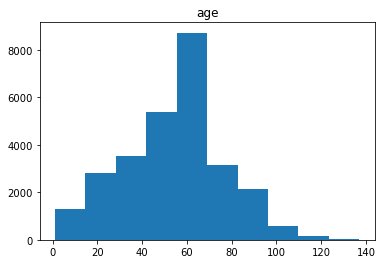

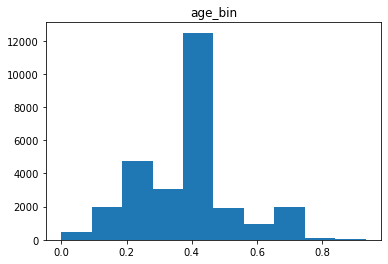

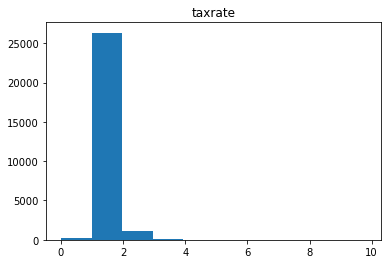

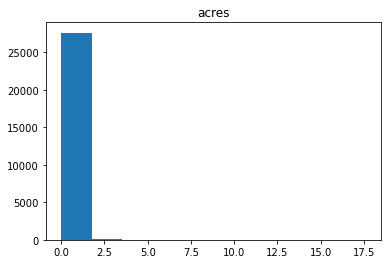

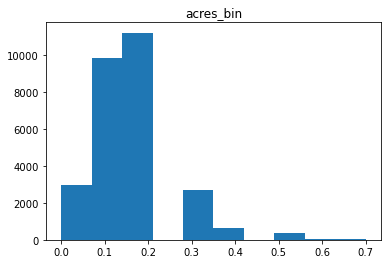

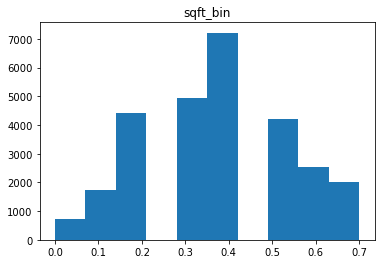

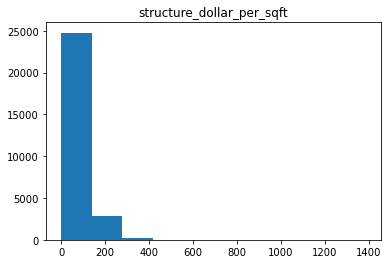

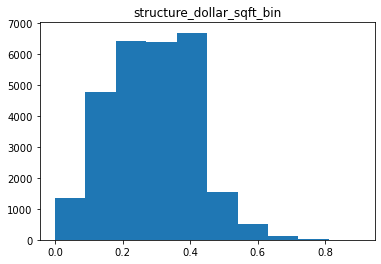

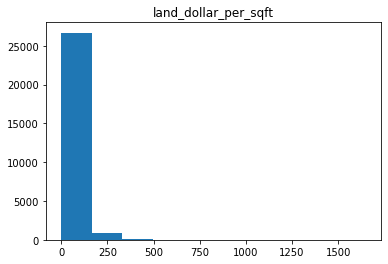

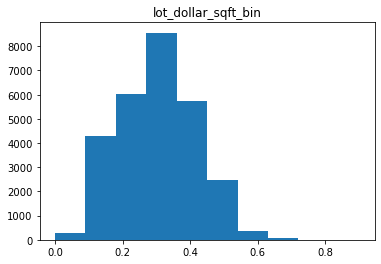

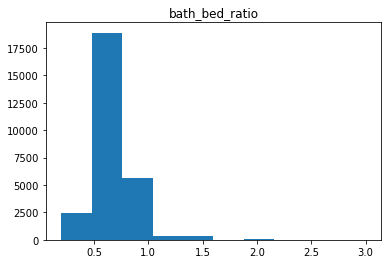

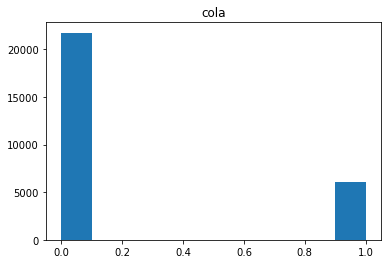

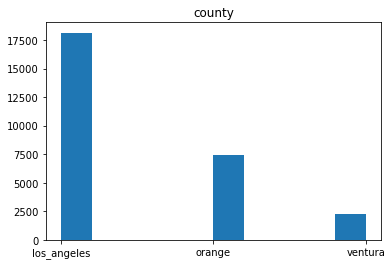

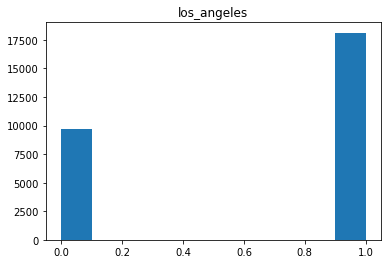

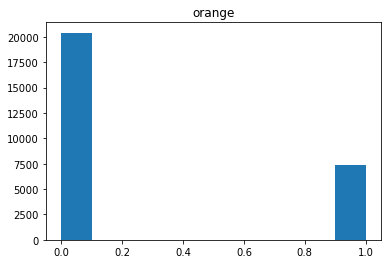

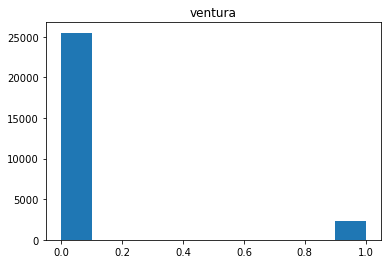

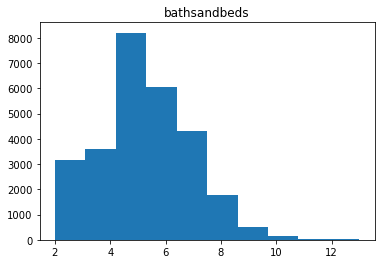

In [13]:
#univariate exploration
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

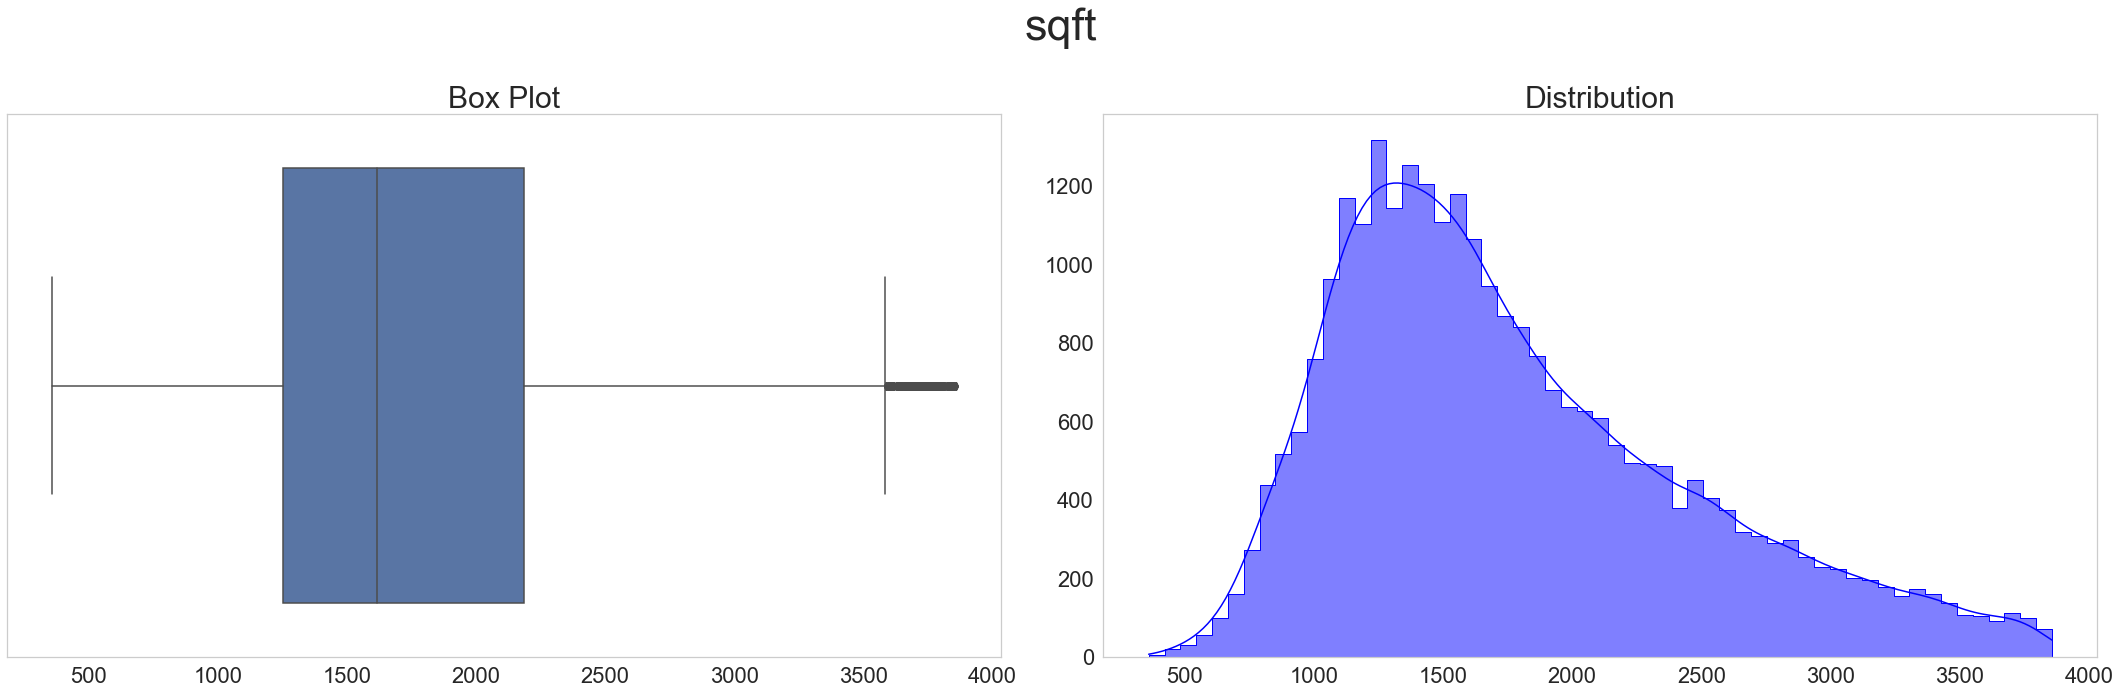

Summary Statistics for sqft
count    27798.000000
mean      1777.331750
std        695.137575
min        360.000000
25%       1253.000000
50%       1617.000000
75%       2186.000000
max       3857.000000
Name: sqft, dtype: float64


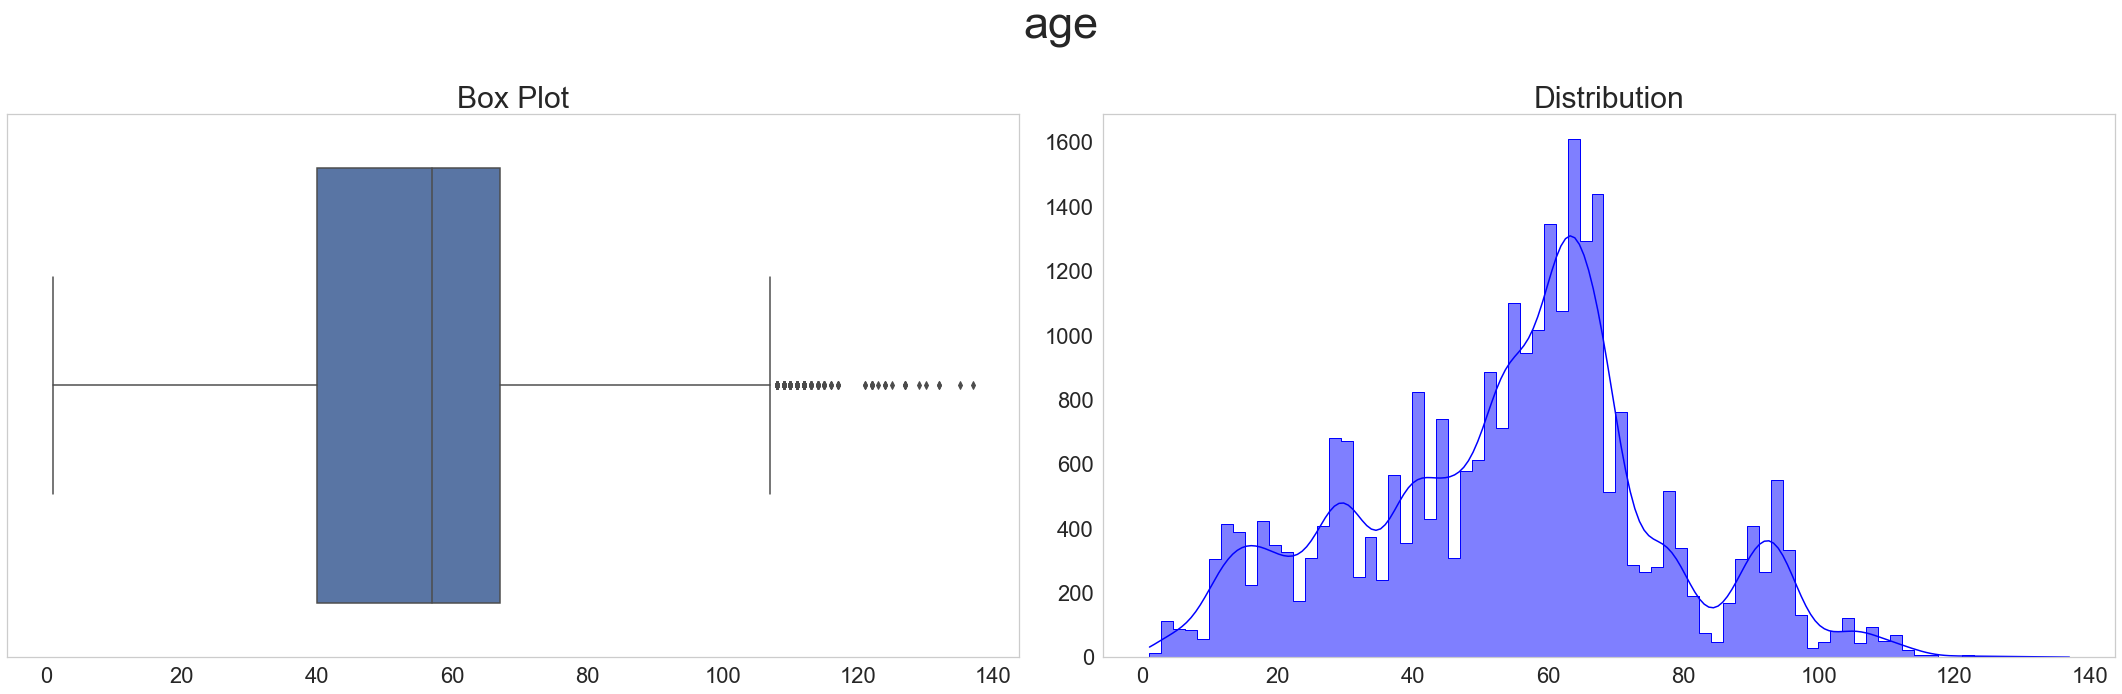

Summary Statistics for age
count    27798.000000
mean        54.711922
std         22.348823
min          1.000000
25%         40.000000
50%         57.000000
75%         67.000000
max        137.000000
Name: age, dtype: float64


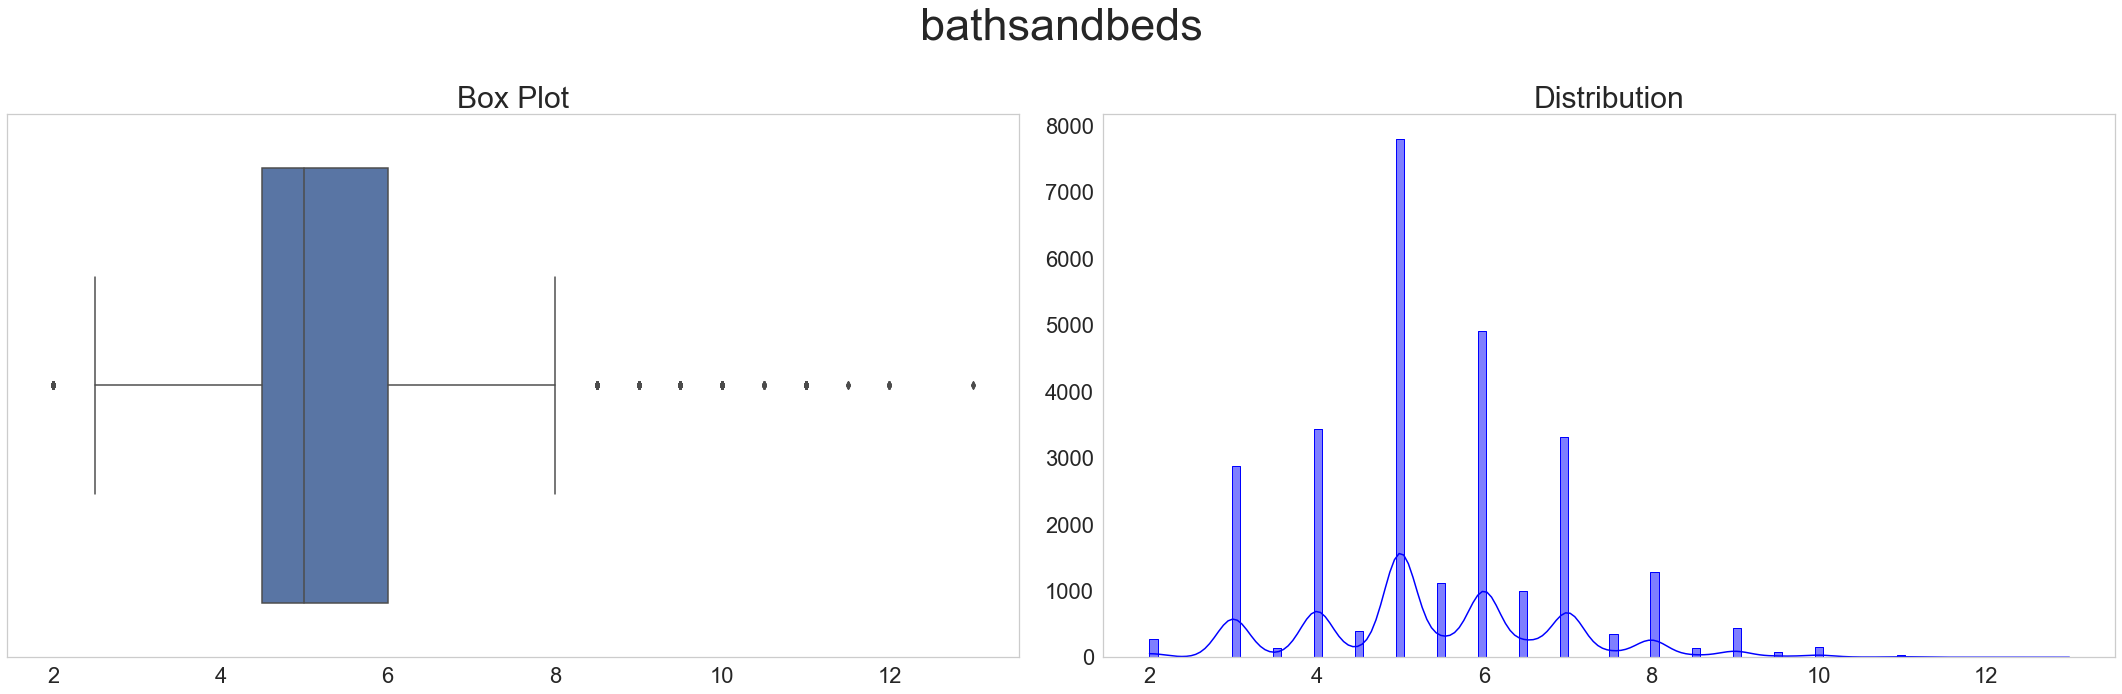

Summary Statistics for bathsandbeds
count    27798.000000
mean         5.421037
std          1.519852
min          2.000000
25%          4.500000
50%          5.000000
75%          6.000000
max         13.000000
Name: bathsandbeds, dtype: float64


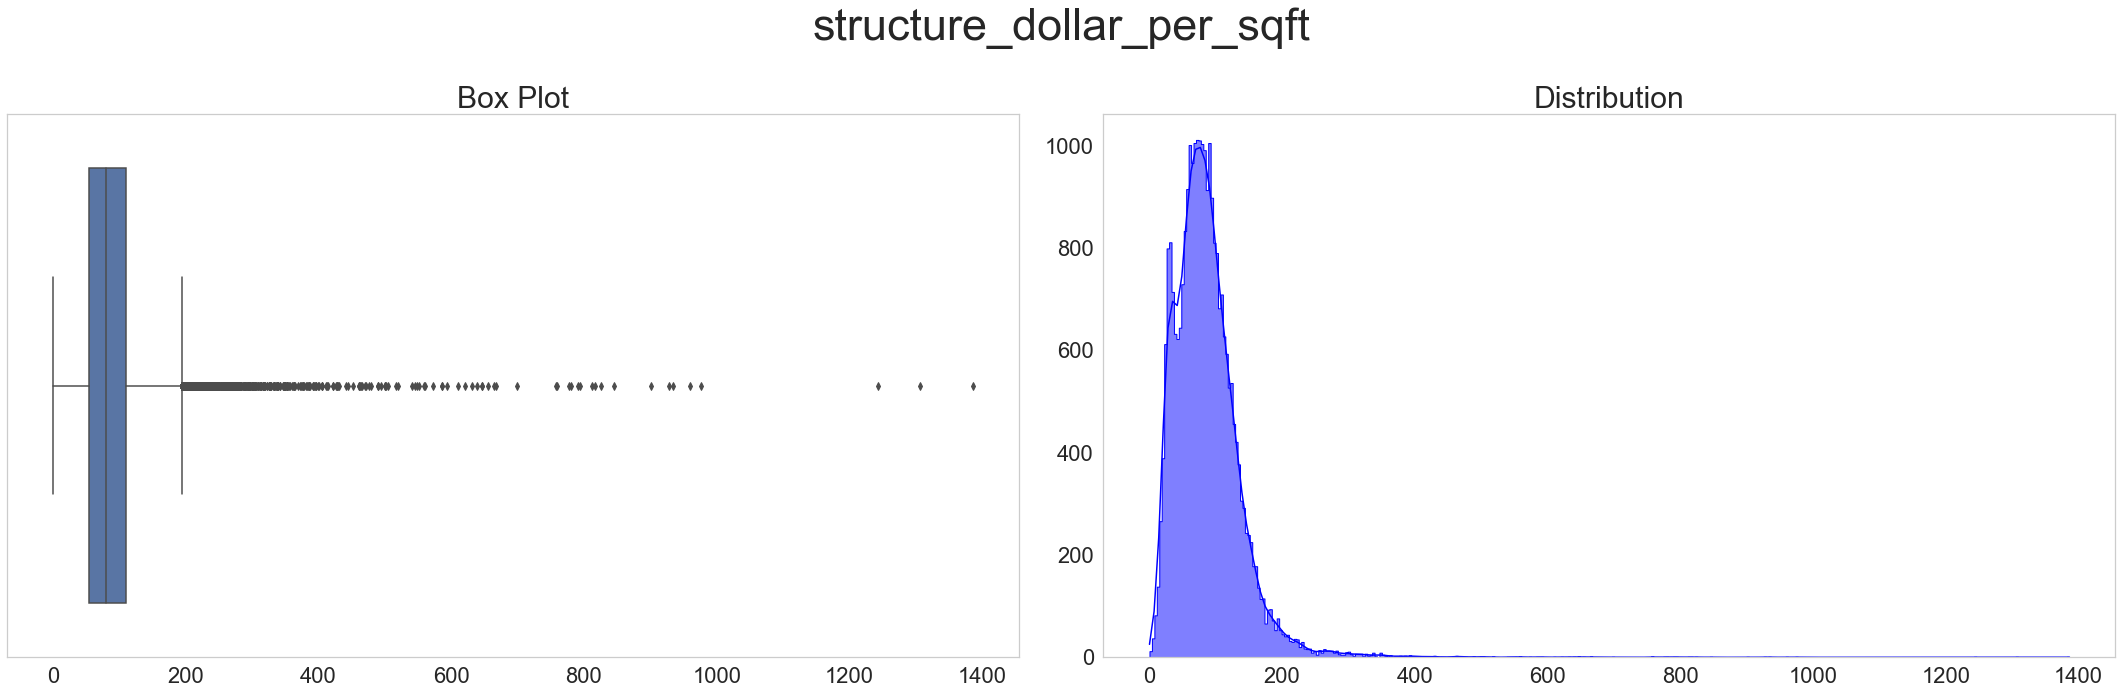

Summary Statistics for structure_dollar_per_sqft
count    27798.000000
mean        87.156388
std         54.826008
min          0.258741
25%         53.913315
50%         80.099439
75%        109.801895
max       1386.370588
Name: structure_dollar_per_sqft, dtype: float64


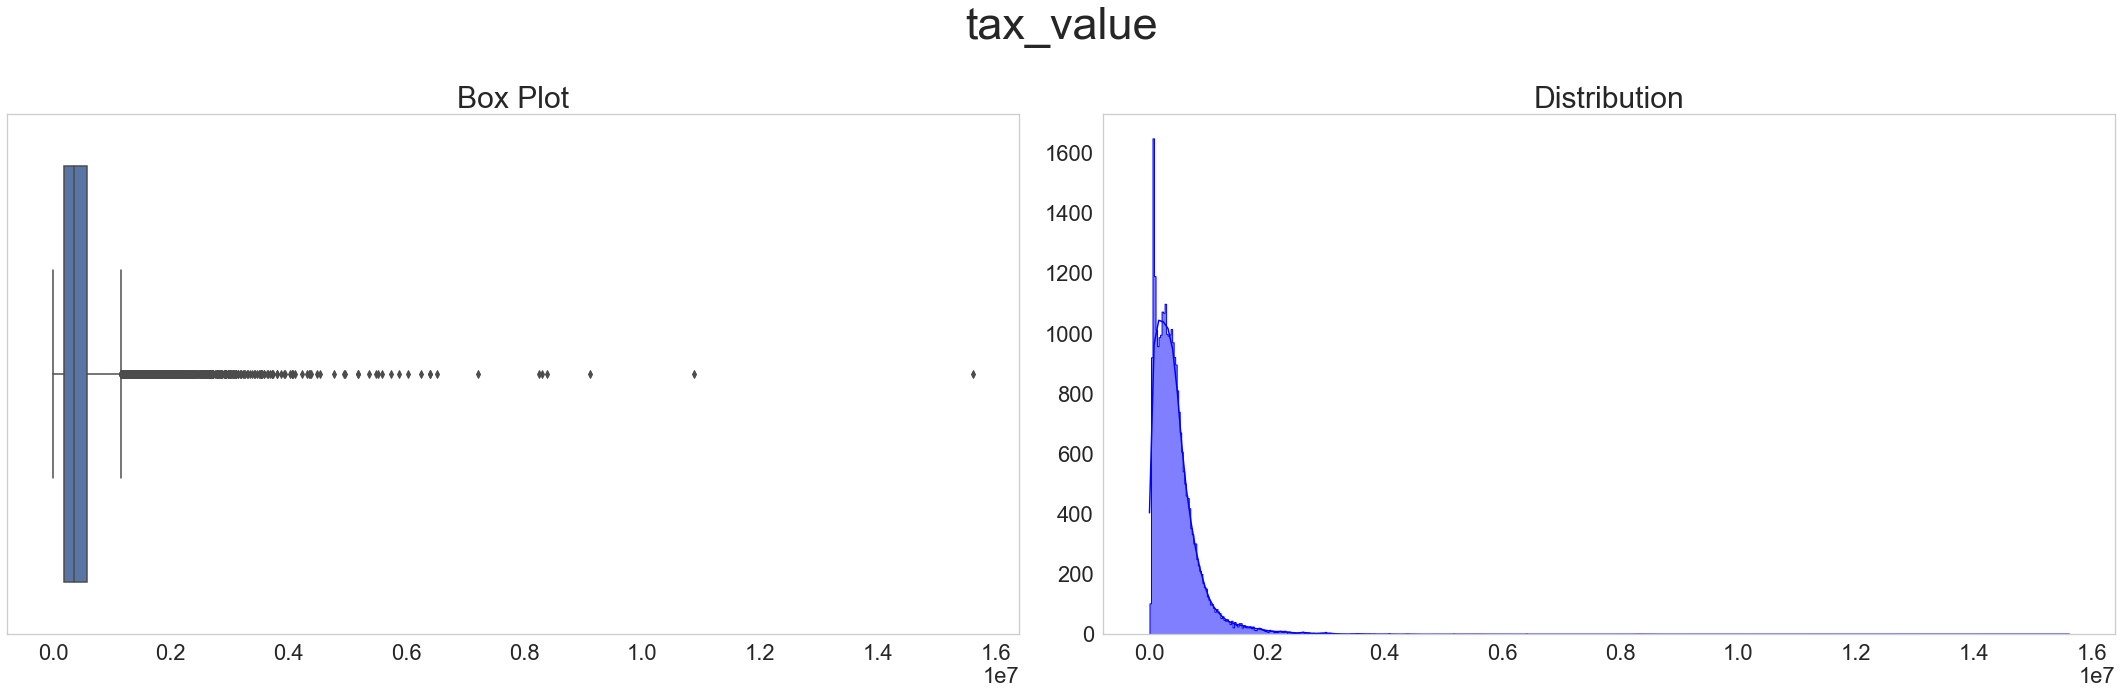

Summary Statistics for tax_value
count    2.779800e+04
mean     4.524594e+05
std      4.489882e+05
min      3.254000e+03
25%      1.861218e+05
50%      3.576760e+05
75%      5.750000e+05
max      1.561849e+07
Name: tax_value, dtype: float64


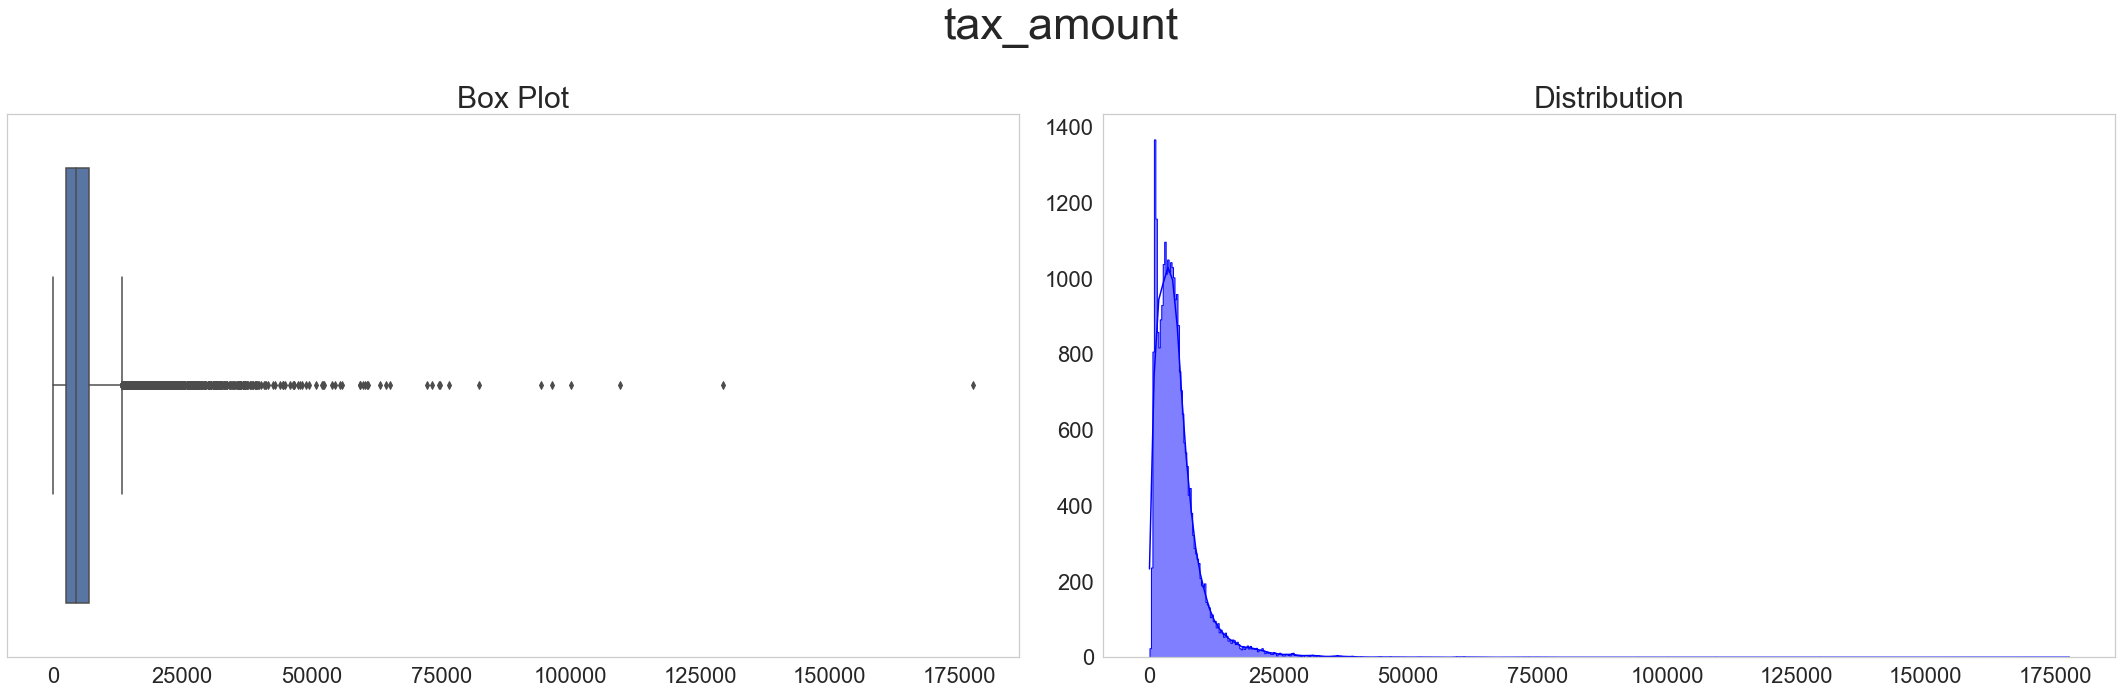

Summary Statistics for tax_amount
count     27798.000000
mean       5550.347738
std        5195.486416
min          49.180000
25%        2569.152500
50%        4464.095000
75%        6881.767500
max      177740.850000
Name: tax_amount, dtype: float64


In [16]:
univariate_stuff = ['sqft','age','bathsandbeds','structure_dollar_per_sqft','tax_value','tax_amount']

for i in univariate_stuff:
    explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

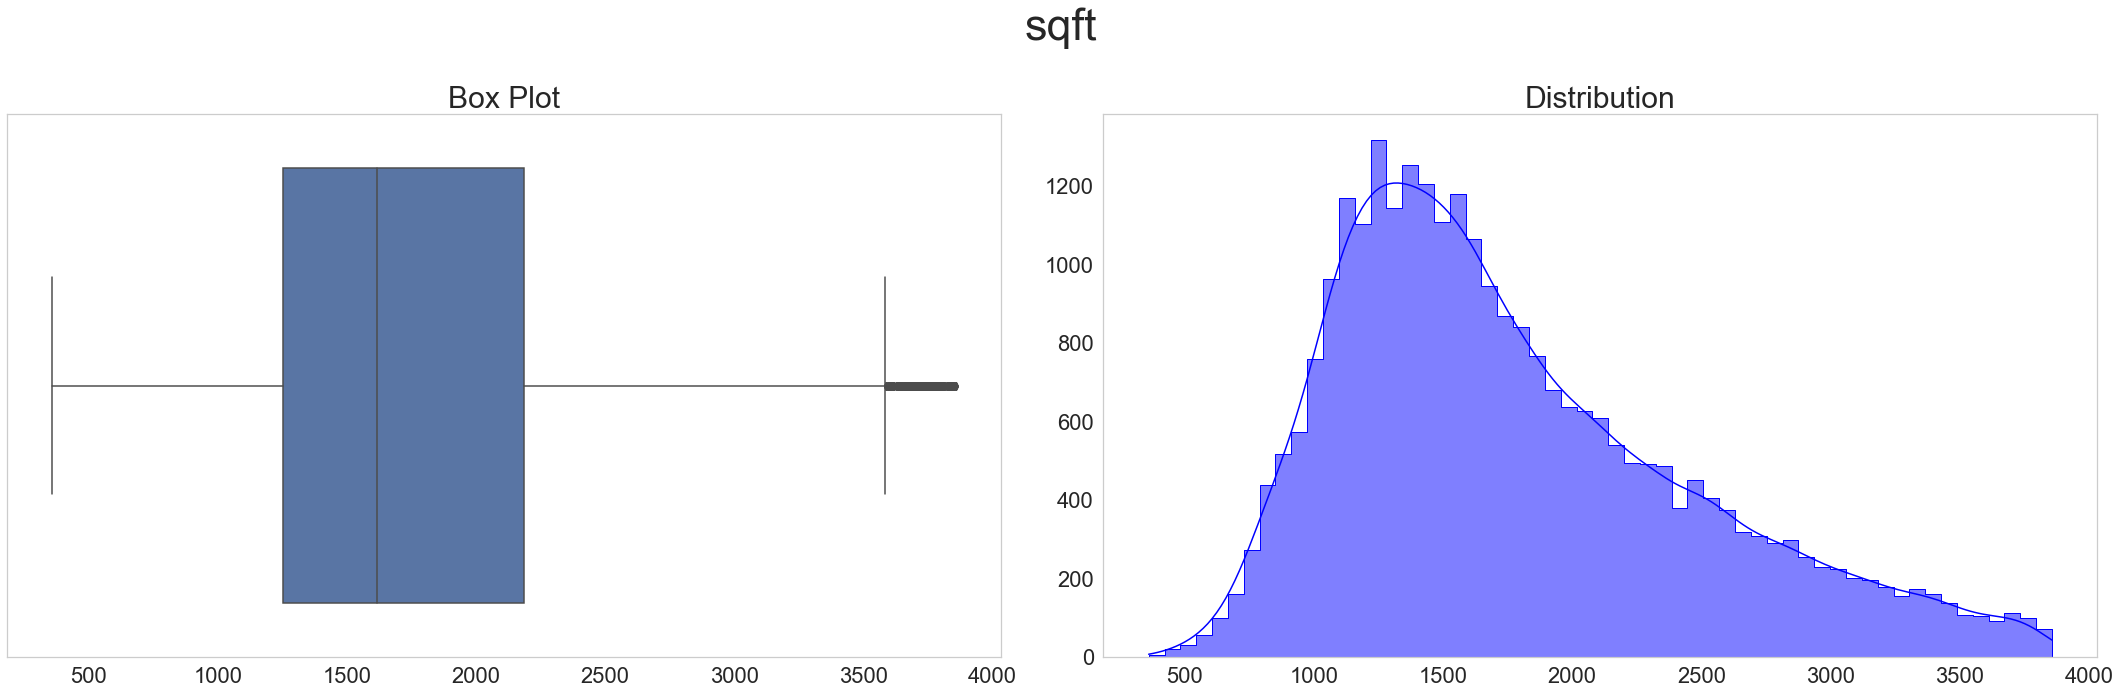

Summary Statistics for Square Footage 
count    27798.000000
mean      1777.331750
std        695.137575
min        360.000000
25%       1253.000000
50%       1617.000000
75%       2186.000000
max       3857.000000
Name: sqft, dtype: float64


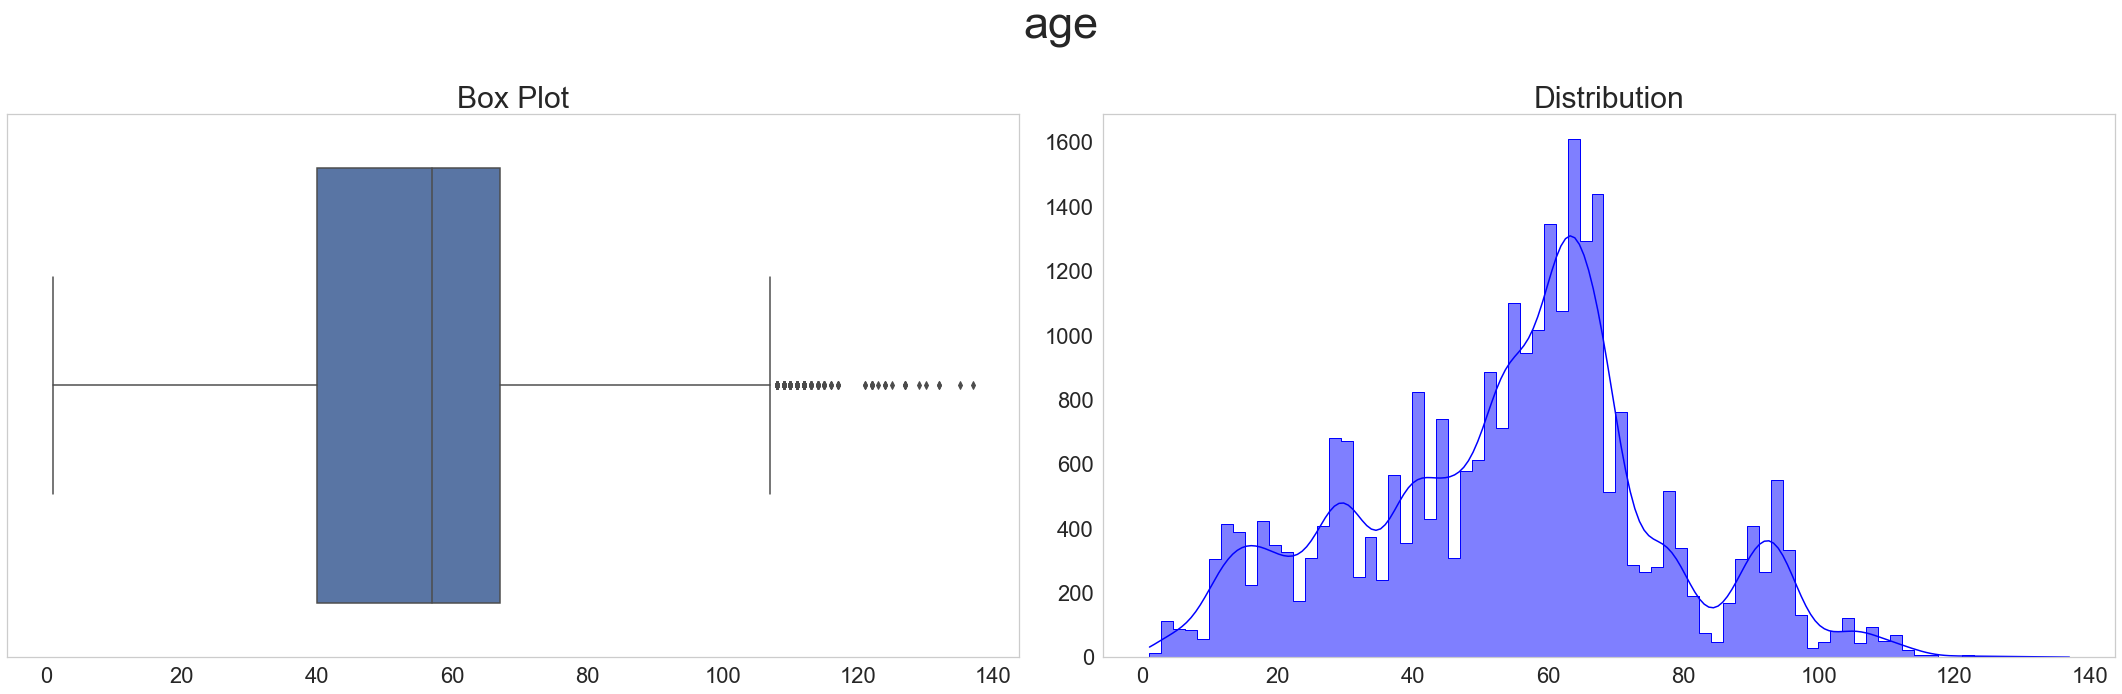

Summary Statistics for Property Age
count    27798.000000
mean        54.711922
std         22.348823
min          1.000000
25%         40.000000
50%         57.000000
75%         67.000000
max        137.000000
Name: age, dtype: float64


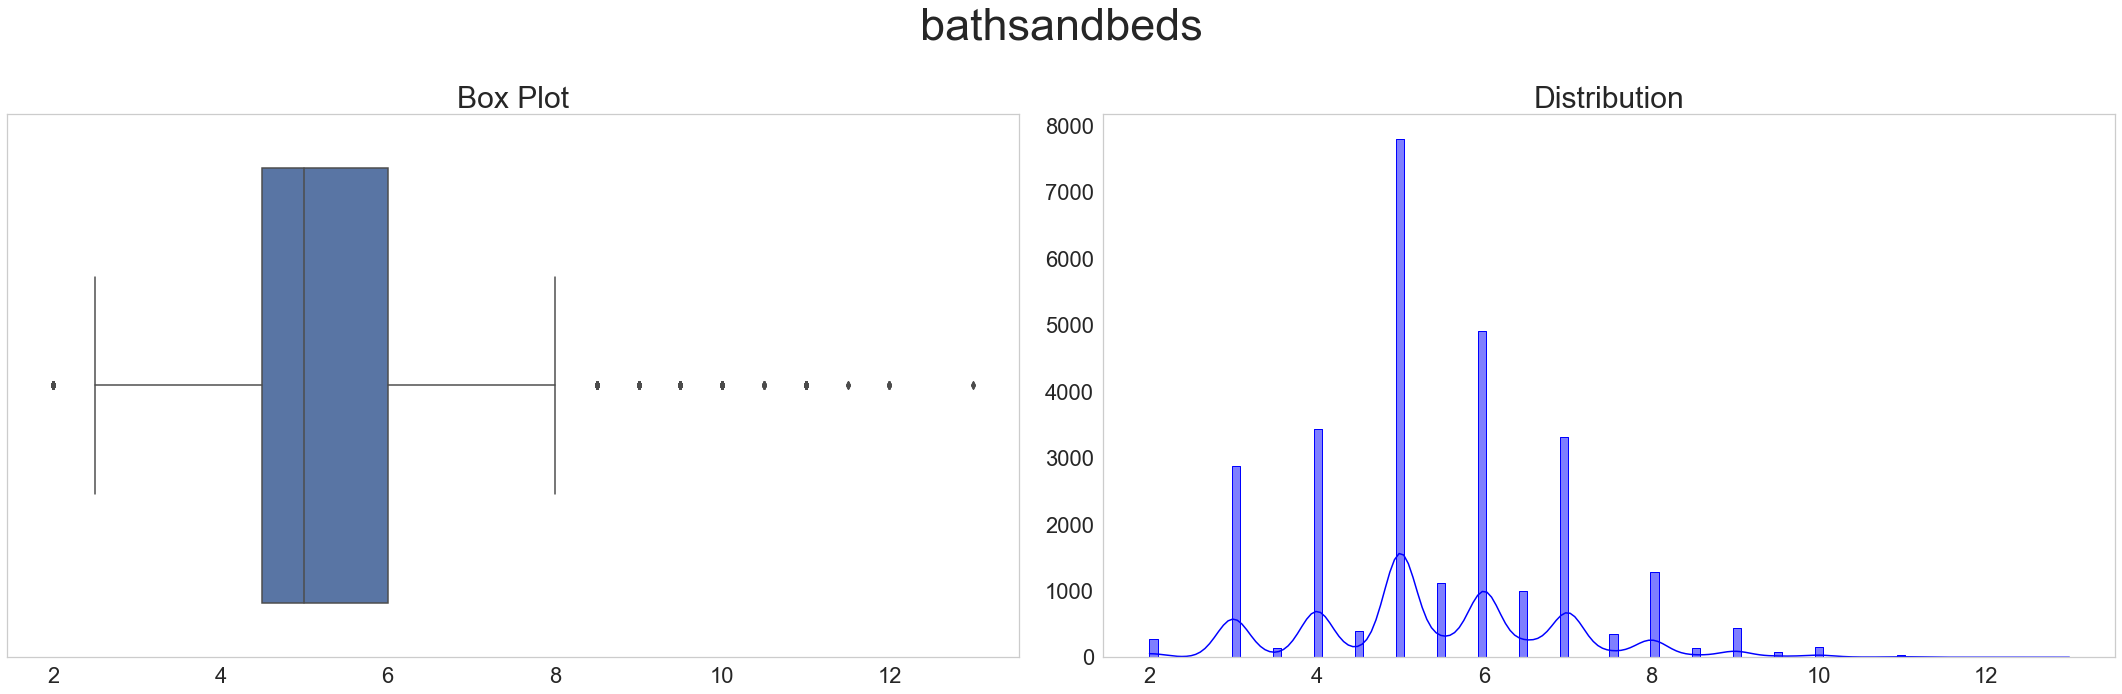

Summary Statistics for Bathrooms and Bedrooms
count    27798.000000
mean         5.421037
std          1.519852
min          2.000000
25%          4.500000
50%          5.000000
75%          6.000000
max         13.000000
Name: bathsandbeds, dtype: float64


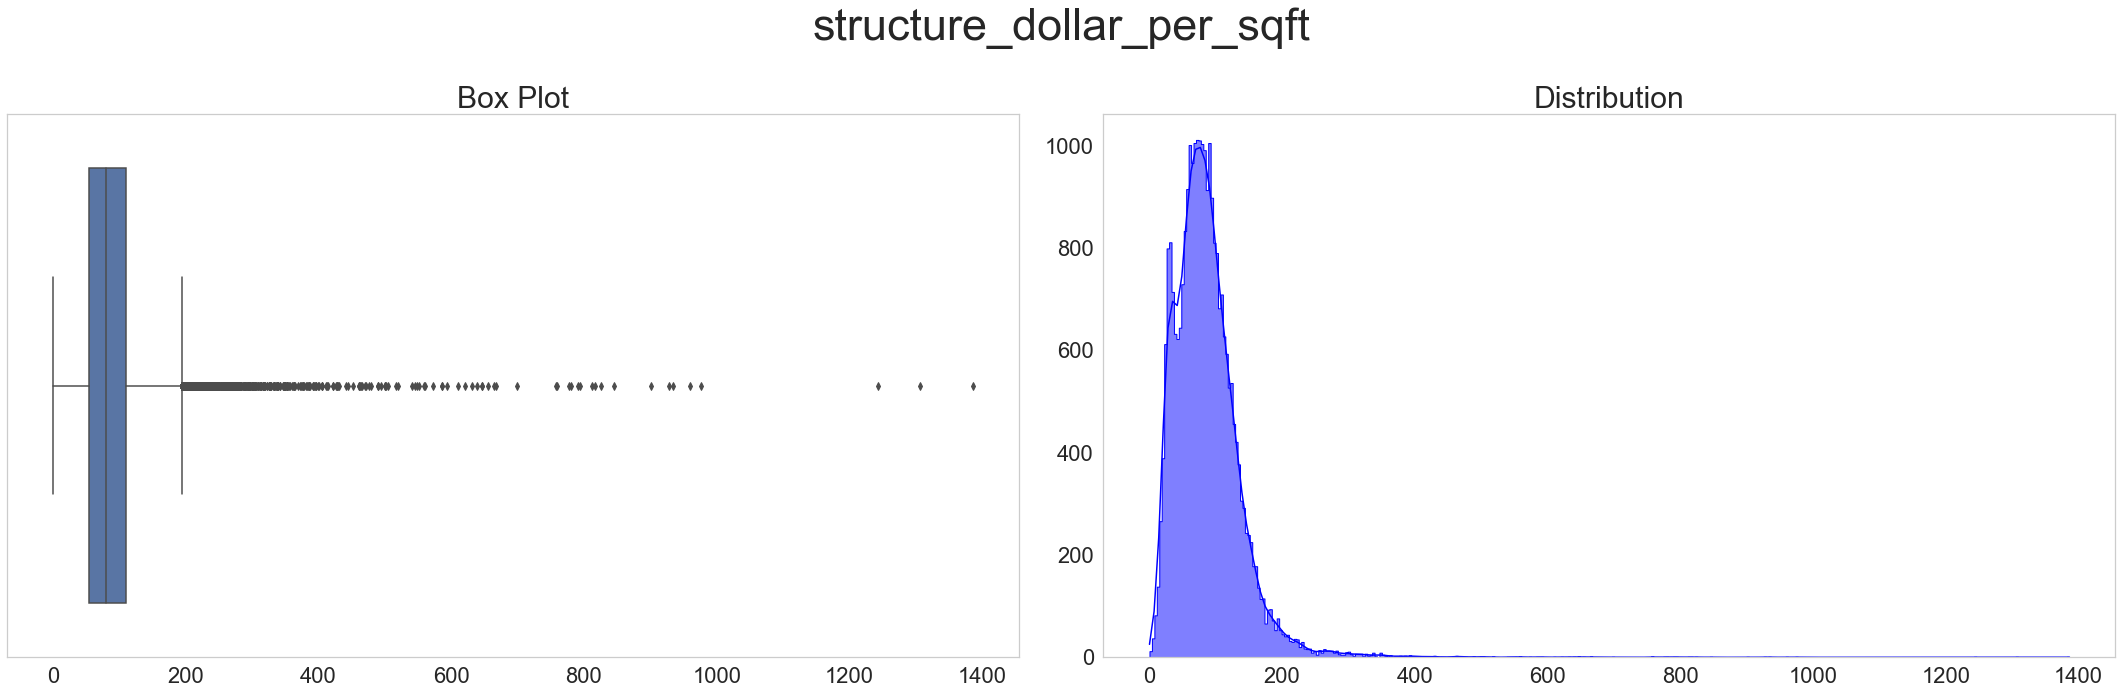

Summary Statistics for Structure Dollar per Sqft
count    27798.000000
mean        87.156388
std         54.826008
min          0.258741
25%         53.913315
50%         80.099439
75%        109.801895
max       1386.370588
Name: structure_dollar_per_sqft, dtype: float64


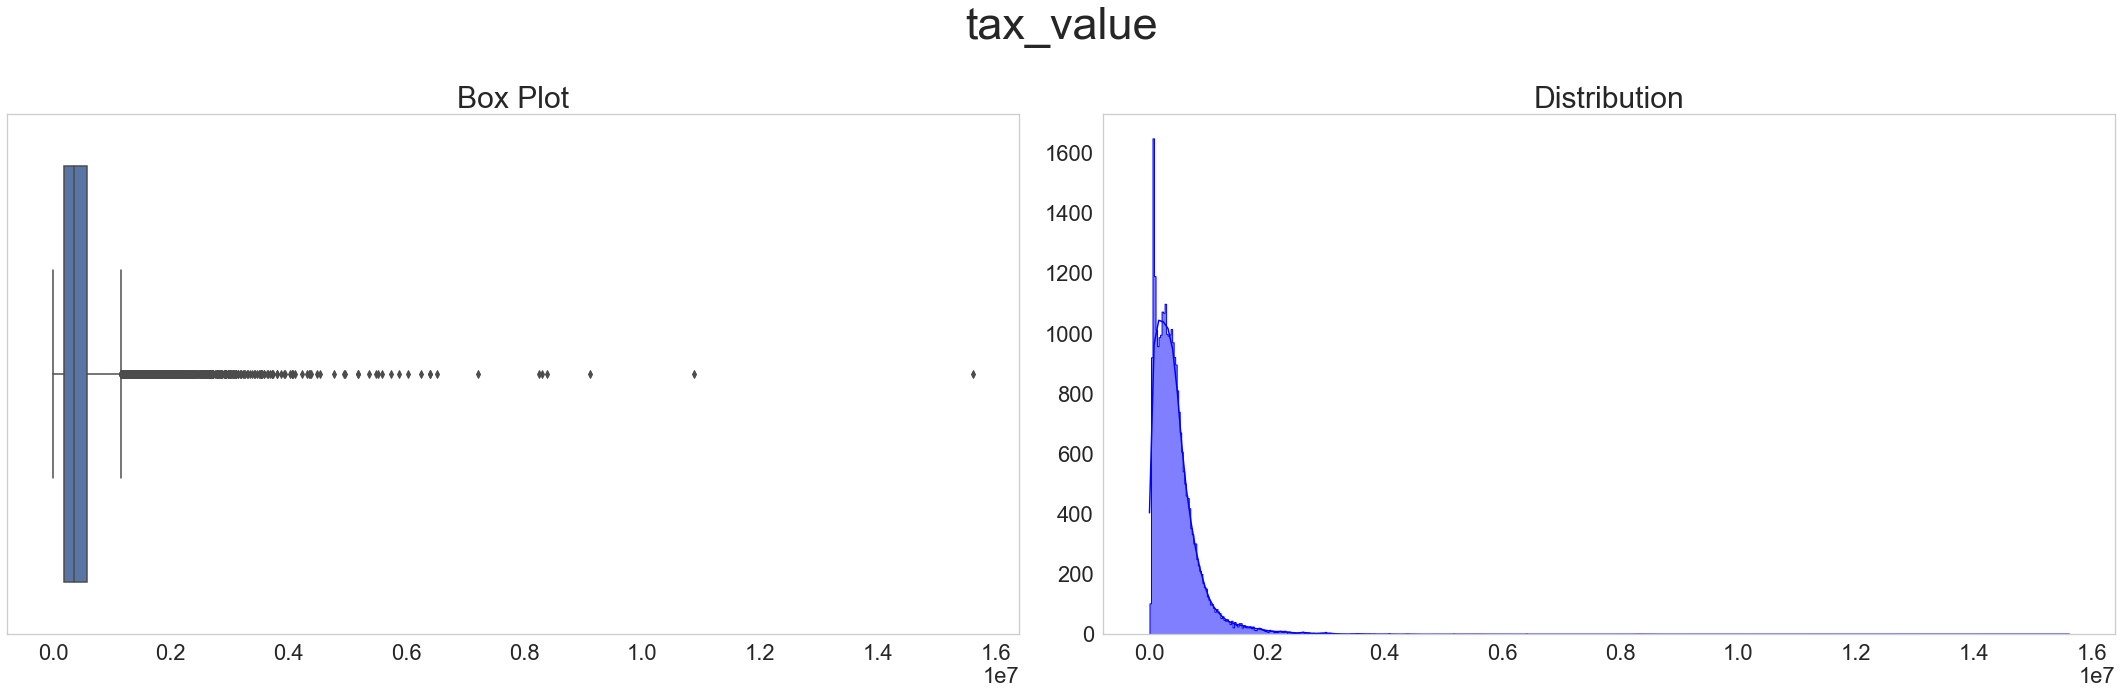

Summary Statistics for Tax Value
count    2.779800e+04
mean     4.524594e+05
std      4.489882e+05
min      3.254000e+03
25%      1.861218e+05
50%      3.576760e+05
75%      5.750000e+05
max      1.561849e+07
Name: tax_value, dtype: float64


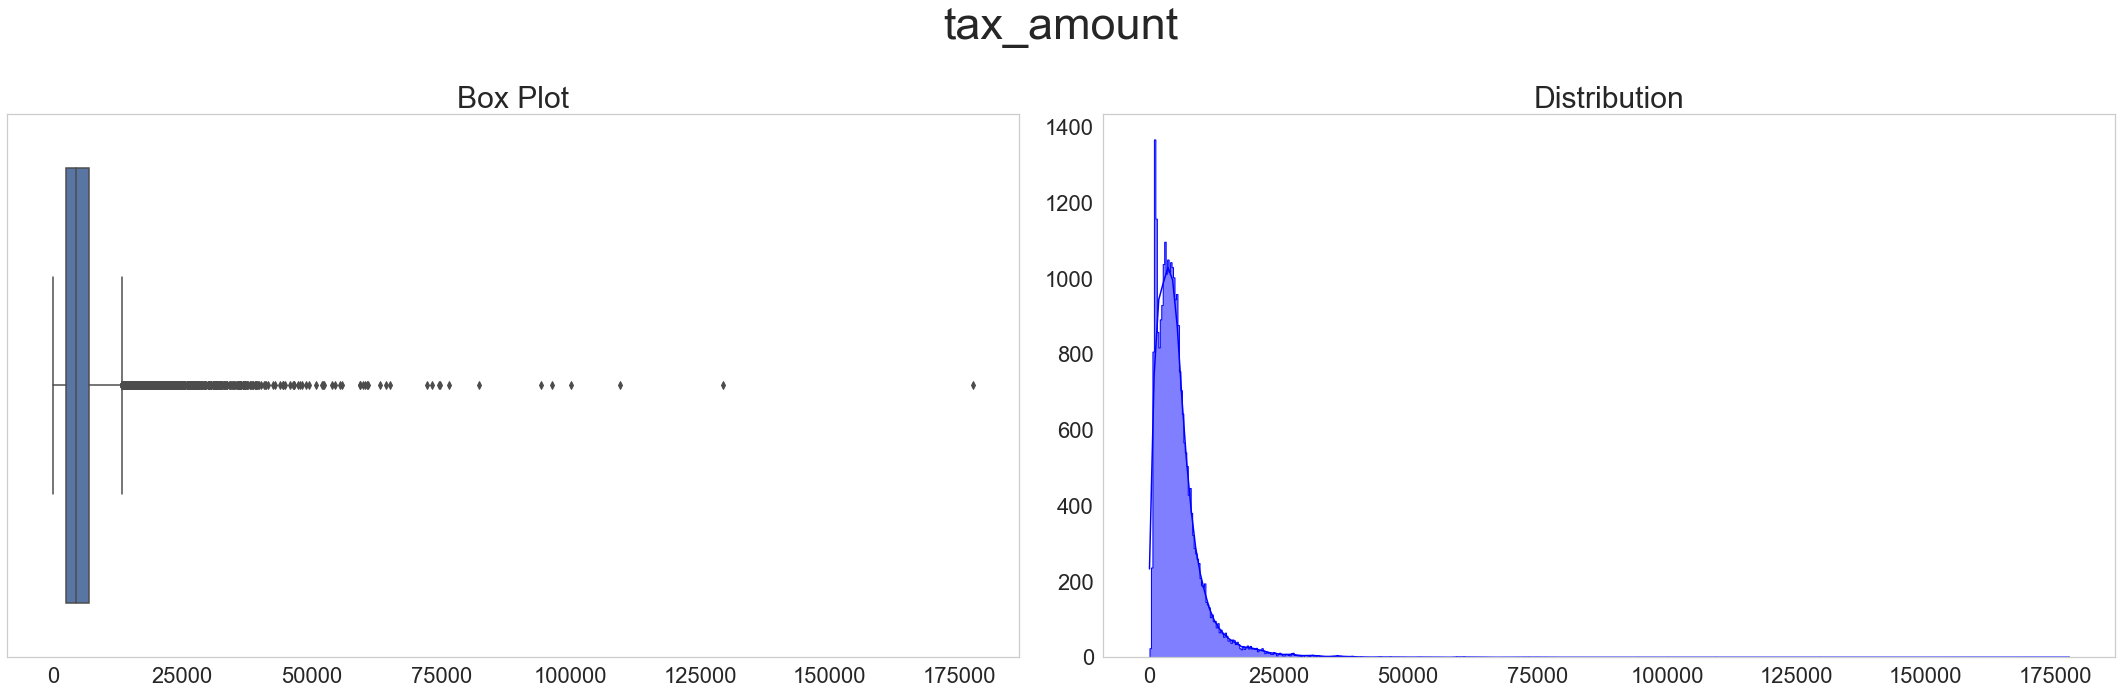

Summary Statistics for Tax Amount
count     27798.000000
mean       5550.347738
std        5195.486416
min          49.180000
25%        2569.152500
50%        4464.095000
75%        6881.767500
max      177740.850000
Name: tax_amount, dtype: float64


In [22]:
# explore_univariate(train, 'sqft')
# print(f'Summary Statistics for Square Footage \n{train.sqft.describe()}')

# explore_univariate(train, 'age')
# print(f'Summary Statistics for Property Age\n{train.age.describe()}')

# explore_univariate(train, 'bathsandbeds')
# print(f'Summary Statistics for Bathrooms and Bedrooms\n{train.bathsandbeds.describe()}')

# explore_univariate(train, 'structure_dollar_per_sqft')
# print(f'Summary Statistics for Structure Dollar per Sqft\n{train.structure_dollar_per_sqft.describe()}')

# explore_univariate(train, 'tax_value')
# print(f'Summary Statistics for Tax Value\n{train.tax_value.describe()}')

# explore_univariate(train, 'tax_amount')
# print(f'Summary Statistics for Tax Amount\n{train.tax_amount.describe()}')


<br>

Takeaways for Univariate: 
 - Normal: number of bathrooms and bedrooms, latitude, and age
 - Skewed right: tax amount, tax value, $ per sqft
 - Skewed left: longitude

<br>

#### Bivariate Exploration

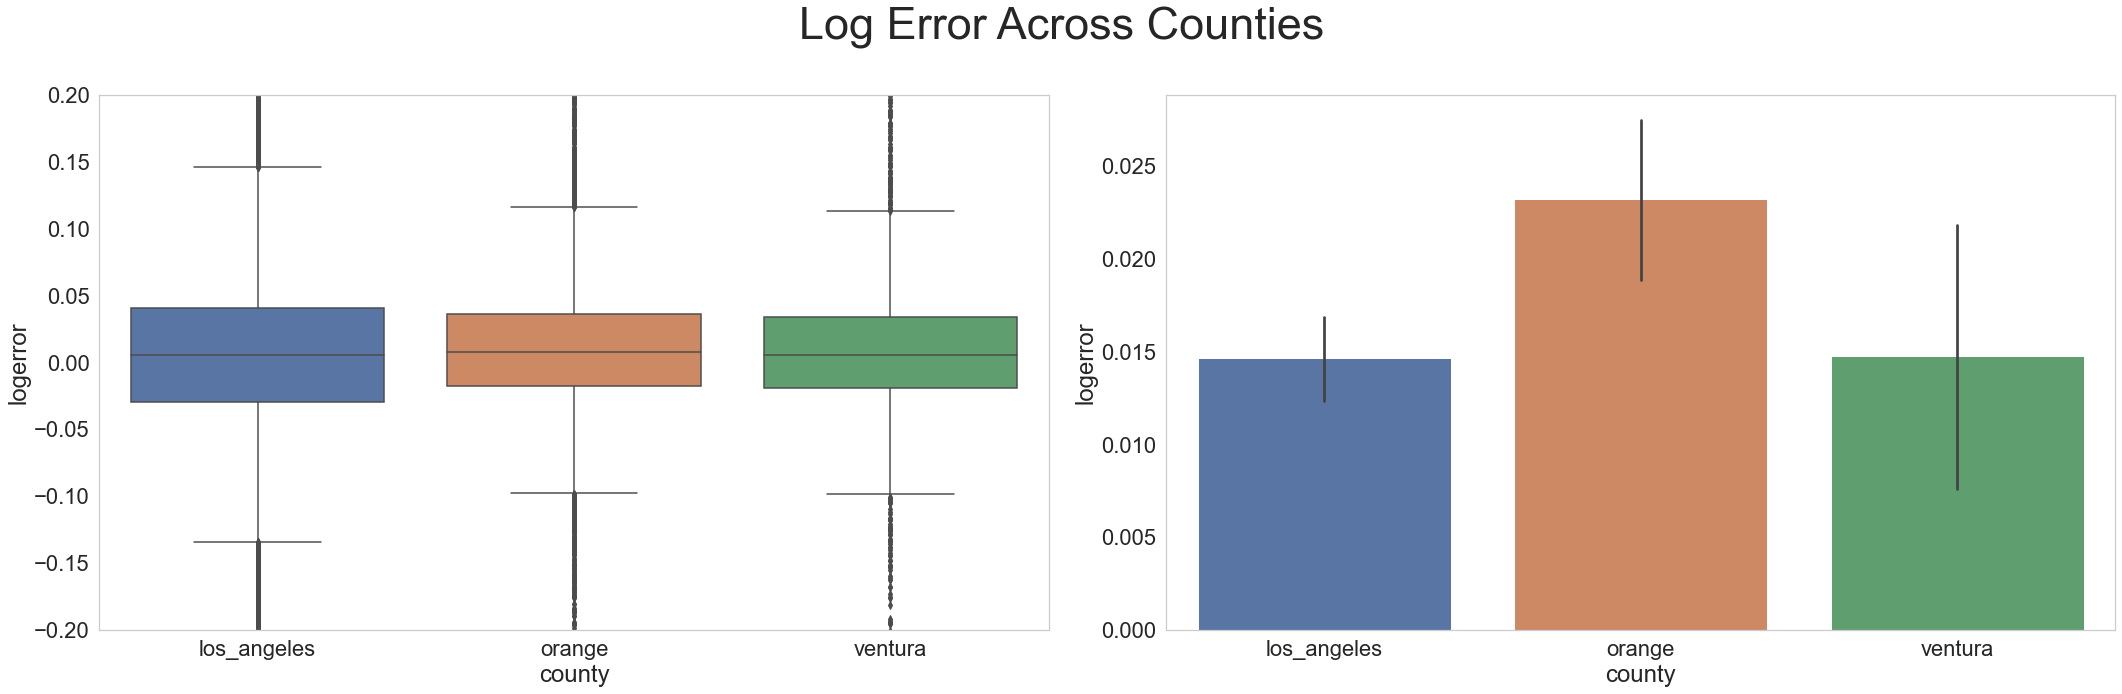

In [34]:
#logerror across counties (LA, Orange, and Ventura)

#set up figure size, font size, and turn off grid.
plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

#boxplot
plt.subplot(1, 2, 1)
sns.boxplot(train.county, train.logerror)
plt.ylim(-.2, .2)

#barplot
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='county',y='logerror')

#title
plt.suptitle('Log Error Across Counties', fontsize = 45)
plt.tight_layout()
plt.show()

In [37]:
null_hypothesis = "no difference in logerror between orange county and the other counties"
alternative_hypothesis = "there is a difference in log error between orange county and other counties"
a = 0.05 #a for alpha 

orange_logerror=train[train.county=='orange'].logerror
other_logerror = train[train.county!='orange'].logerror
t, p = stats.ttest_ind(orange_logerror, other_logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between orange county and the other counties
There is evidence to suggest: there is a difference in log error between orange county and other counties


<br>

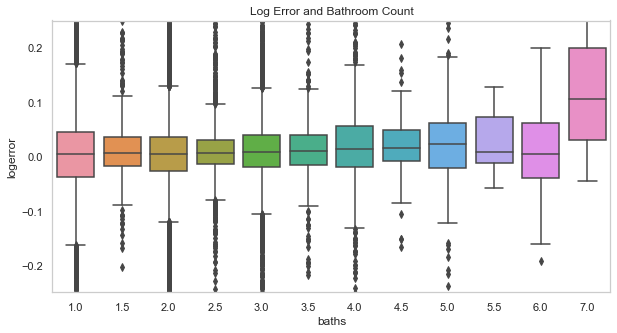

In [43]:
#Log error and number of bathrooms
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(train.baths, train.logerror)
plt.title('Log Error and Bathroom Count')
plt.ylim(-.25, .25)
plt.show()

In [44]:
null_hypothesis = "no difference in logerror between properties with 3 bathrooms or less, or more bathrooms"
alternative_hypothesis = "there is a difference in logerror between properties with 3 bathrooms or less, or more bathrooms"
a = 0.05 #a for alpha 

three_or_less_baths=train[train.baths<=3].logerror
more_than_three_baths = train[train.baths>3].logerror
t, p = stats.ttest_ind(three_or_less_baths, more_than_three_baths)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties with 3 bathrooms or less, or more bathrooms
There is evidence to suggest: there is a difference in logerror between properties with 3 bathrooms or less, or more bathrooms


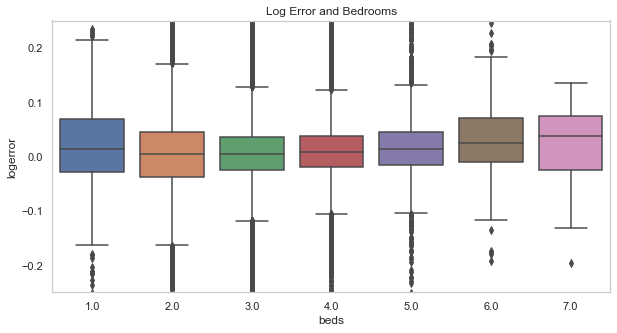

In [53]:
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(train.beds, train.logerror)
plt.title('Log Error and Bedrooms')
plt.ylim(-.25, .25)
plt.show()

In [46]:
null_hypothesis = "no difference in logerror between properties with 3 bedrooms or less, or more bedrooms"
alternative_hypothesis = "there is a difference in logerror between properties with 3 bedrooms or less, or more bedrooms"
a = 0.05 #a for alpha 

three_or_less_beds=train[train.beds<=3].logerror
more_than_three_beds = train[train.beds>3].logerror
t, p = stats.ttest_ind(three_or_less_beds, more_than_three_beds)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties with 3 bedrooms or less, or more bedrooms
There is evidence to suggest: there is a difference in logerror between properties with 3 bedrooms or less, or more bedrooms


Sqft and LogError


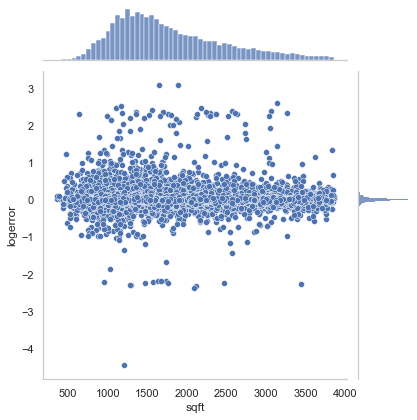

In [50]:
print('Sqft and LogError')
sns.jointplot(x='sqft', y='logerror', data=train)
plt.xlabel('Sqft')
plt.ylabel('Log Error')
plt.show()

In [48]:
null_hypothesis = "no difference in logerror between properties 2000 sqft or less, or with more square footage"
alternative_hypothesis = "there is a difference in logerror between properties 2000 sqft or less, or with more square footage"
a = 0.05 #a for alpha 

big_house=train[train.sqft<=2000].logerror
small_house = train[train.sqft>2000].logerror
t, p = stats.ttest_ind(big_house, small_house)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties 2000 sqft or less, or with more square footage
There is evidence to suggest: there is a difference in logerror between properties 2000 sqft or less, or with more square footage


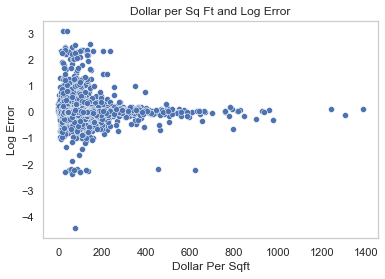

In [54]:
sns.scatterplot(x='structure_dollar_per_sqft', y='logerror', data=train)
plt.xlabel('Dollar Per Sqft')
plt.ylabel('Log Error')
plt.title('Dollar per Sq Ft and Log Error')
plt.show()

In [55]:
null_hypothesis = "no difference in logerror between dollar per sqft"
alternative_hypothesis = "there is a difference in logerror between dollar per sqft"
a = 0.05 #a for alpha 

corr, p = stats.pearsonr(train.structure_dollar_per_sqft,train.logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between dollar per sqft
There is evidence to suggest: there is a difference in logerror between dollar per sqft


In [56]:
#let's add log error bins so we can check out a cool pairplot
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

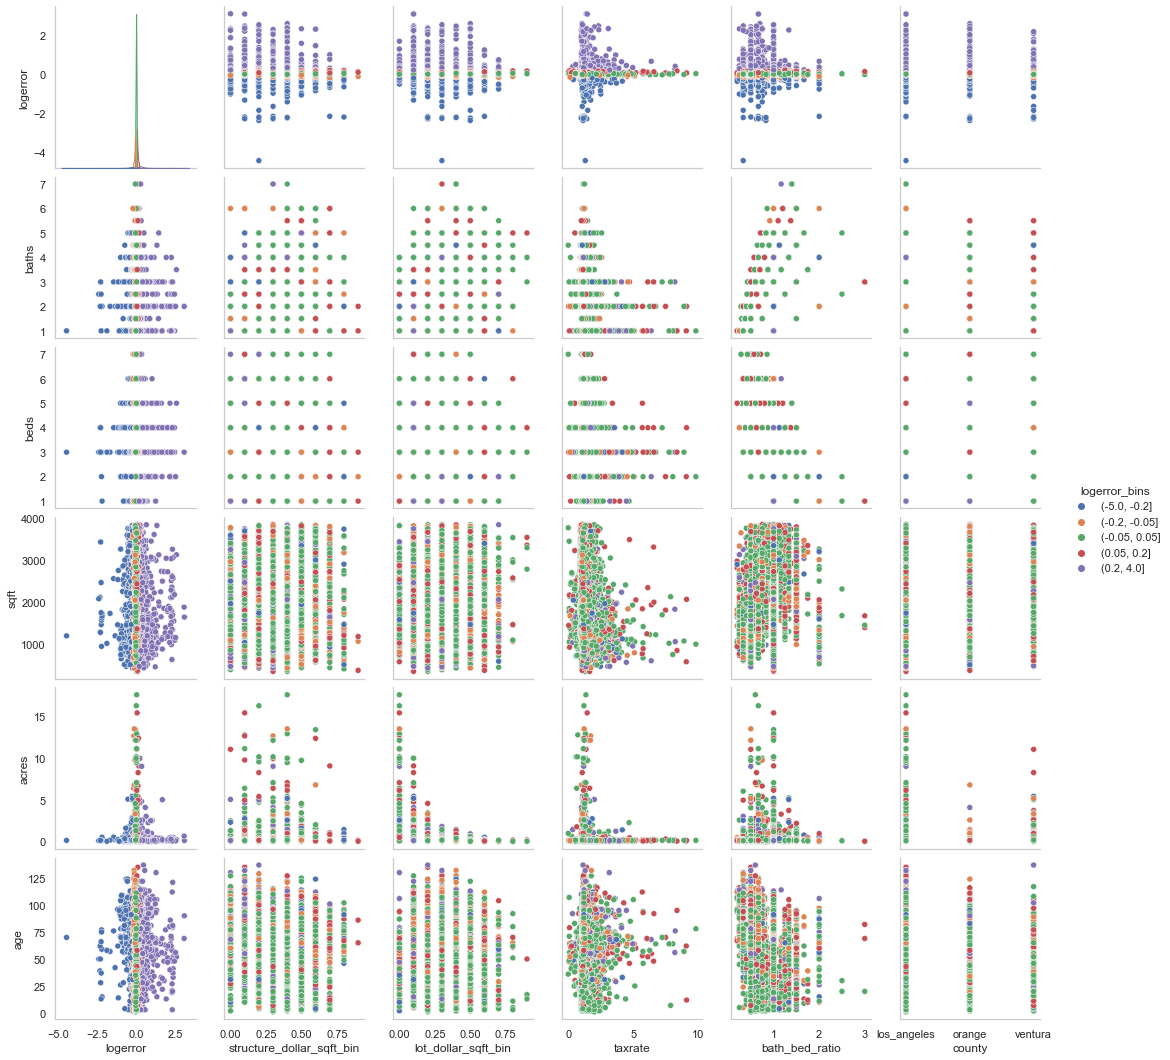

In [57]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror','structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio','county'],
             y_vars = ['logerror', 'baths','beds', 'sqft', 'acres', 'age'])

<AxesSubplot:title={'center':'Feautures Correlating with Log Error'}>

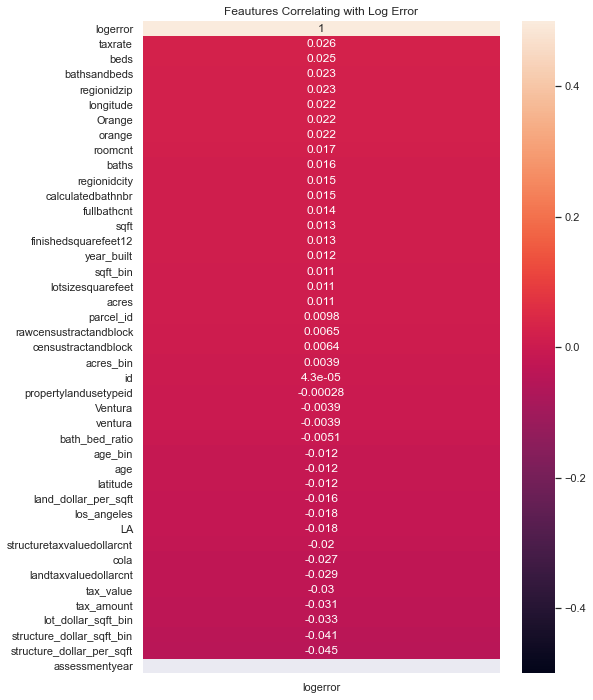

In [14]:
#let's look at a heatmap to see what features correlate with log error.
get_zillow_heatmap(train)

### Multivariate Exploration

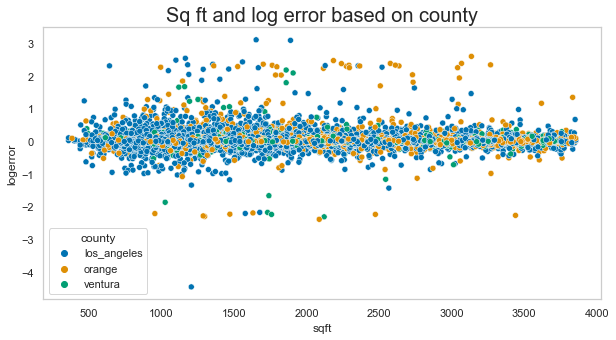

In [64]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='sqft',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Sq ft and log error based on county', fontsize = 20)
plt.show()

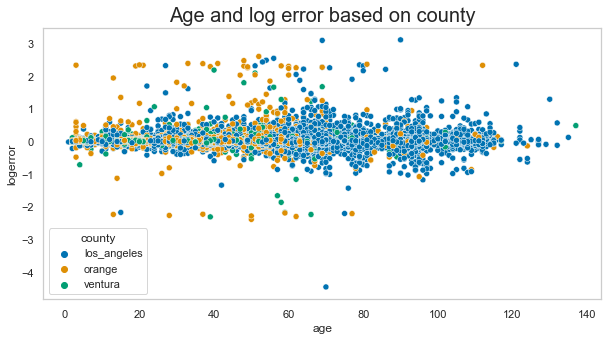

In [67]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Age and log error based on county', fontsize=20)
plt.show()

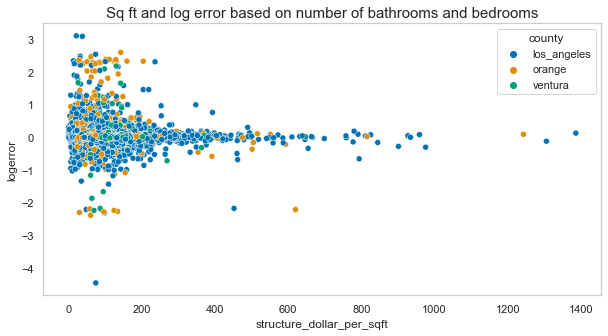

In [75]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

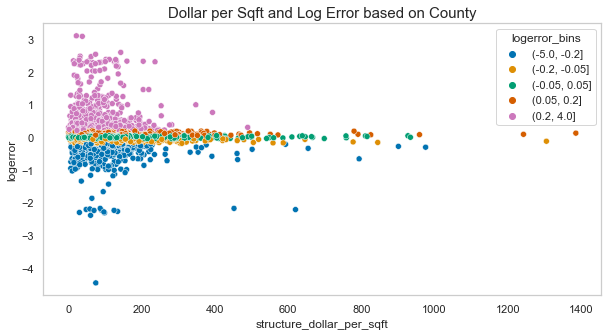

In [76]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='logerror_bins', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

Clusters based on age property and square footage


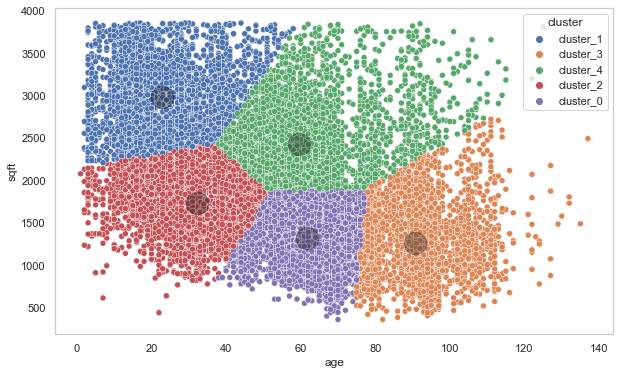

In [79]:
X = train[['age', 'sqft']]
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)
create_scatter_plot('age','sqft',train,kmeans, X_scaled, scaler)
print('Clusters based on age property and square footage')

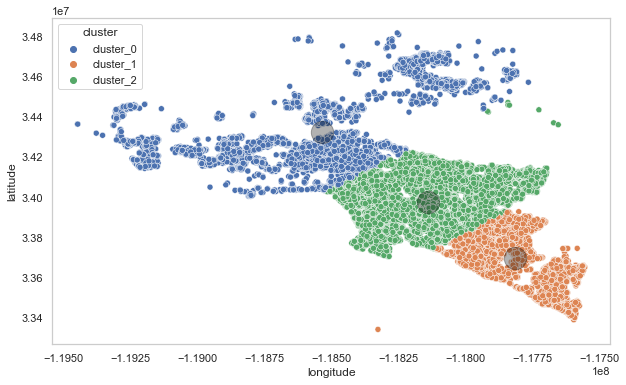

In [80]:
X = train[['longitude', 'latitude']]
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 3)
create_scatter_plot('longitude','latitude',train,kmeans, X_scaled, scaler)

In [109]:
X_features = train[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
X_features.columns

Index(['structure_dollar_per_sqft', 'age', 'bathsandbeds'], dtype='object')

In [110]:
X = X_train_scaled[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
# define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

X_train_scaled['cluster'] = kmeans.predict(X)
X_train_scaled.sample(5)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features.columns)

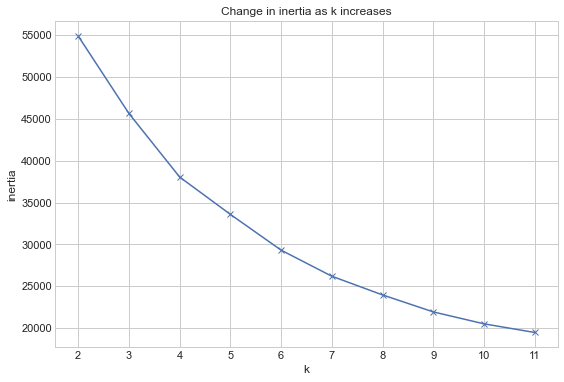

In [111]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

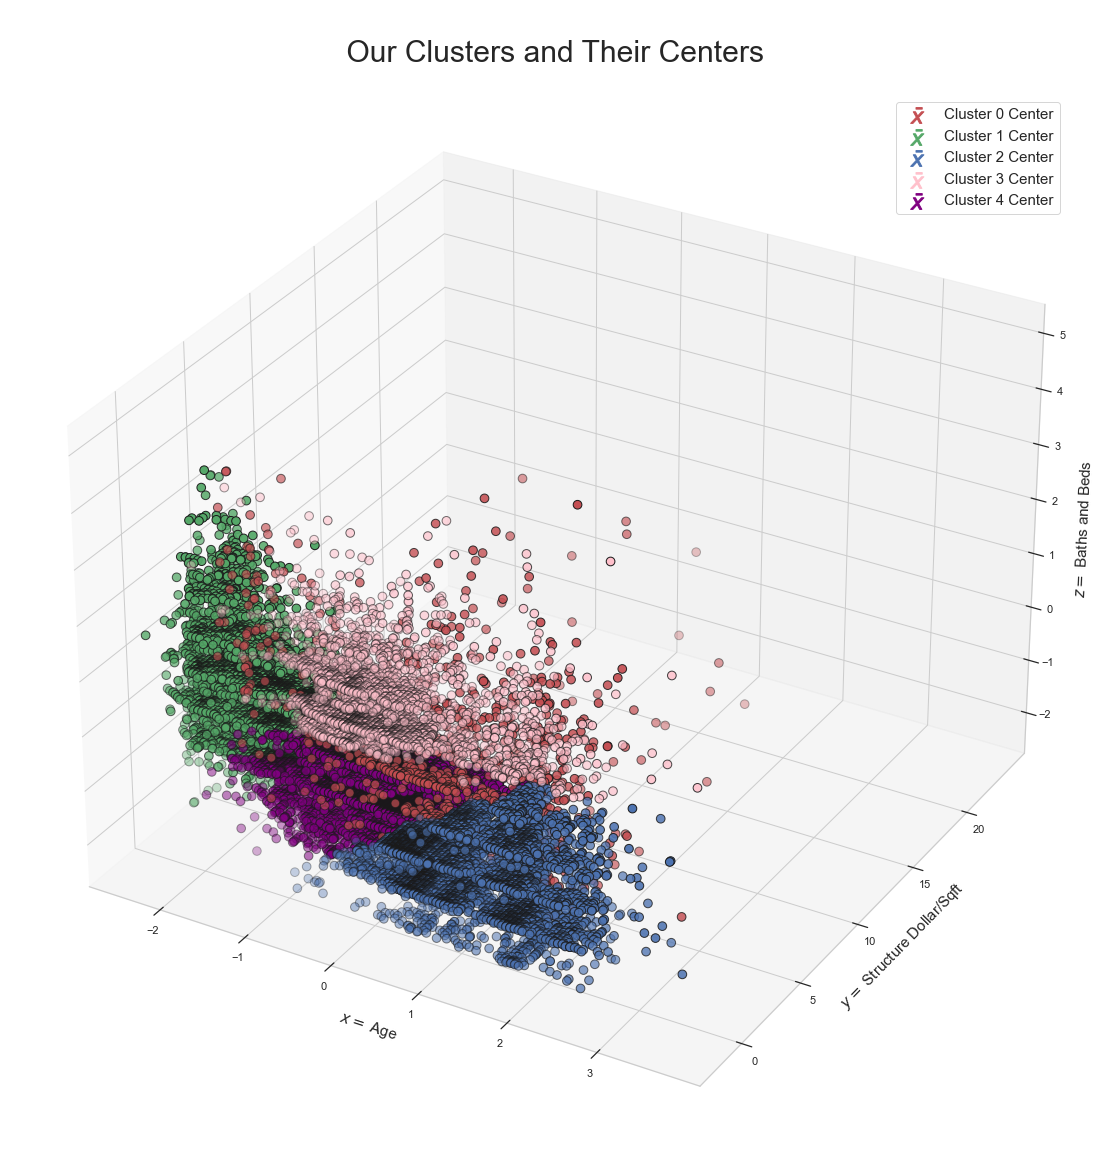

In [96]:
#%matplotlib osx
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# set x for each cluster
x0 = X_train_scaled[X_train_scaled['cluster'] == 0]['age']
x1 = X_train_scaled[X_train_scaled['cluster'] == 1]['age']
x2 = X_train_scaled[X_train_scaled['cluster'] == 2]['age']
x3 = X_train_scaled[X_train_scaled['cluster'] == 3]['age']
x4 = X_train_scaled[X_train_scaled['cluster'] == 4]['age']


# set y for each cluster
y0 = X_train_scaled[X_train_scaled['cluster'] == 0]['structure_dollar_per_sqft']
y1 = X_train_scaled[X_train_scaled['cluster'] == 1]['structure_dollar_per_sqft']
y2 = X_train_scaled[X_train_scaled['cluster'] == 2]['structure_dollar_per_sqft']
y3 = X_train_scaled[X_train_scaled['cluster'] == 3]['structure_dollar_per_sqft']
y4 = X_train_scaled[X_train_scaled['cluster'] == 4]['structure_dollar_per_sqft']

# set z for each cluster
z0 = X_train_scaled[X_train_scaled['cluster'] == 0]['bathsandbeds']
z1 = X_train_scaled[X_train_scaled['cluster'] == 1]['bathsandbeds']
z2 = X_train_scaled[X_train_scaled['cluster'] == 2]['bathsandbeds']
z3 = X_train_scaled[X_train_scaled['cluster'] == 3]['bathsandbeds']
z4 = X_train_scaled[X_train_scaled['cluster'] == 4]['bathsandbeds']

zero_center = centroids[centroids.index == 0]
one_center = centroids[centroids.index == 1]
two_center = centroids[centroids.index == 2]
three_center = centroids[centroids.index == 3]
four_center = centroids[centroids.index == 4]

# plot cluster 0 with center
ax.scatter(x0, y0, z0, s=75, c='r', edgecolor='k', marker='o')
ax.scatter(zero_center.age, zero_center.structure_dollar_per_sqft, zero_center.bathsandbeds, s=250, c='r', marker='$\\bar{x}$', label='Cluster 0 Center')
# plot cluster 1 with center
ax.scatter(x1, y1, z1, s=75, c='g', edgecolor='k', marker='o')
ax.scatter(one_center.age, one_center.structure_dollar_per_sqft, one_center.bathsandbeds, s=250, c='g', marker='$\\bar{x}$', label='Cluster 1 Center')
# plot cluster 2 with center
ax.scatter(x2, y2, z2, s=75, c='b', edgecolor='k', marker='o')
ax.scatter(two_center.age, two_center.structure_dollar_per_sqft, two_center.bathsandbeds, s=250, c='b', marker='$\\bar{x}$', label='Cluster 2 Center')
#plot cluster 3 with center
ax.scatter(x3, y3, z3, s=75, c='pink', edgecolor='k', marker='o')
ax.scatter(three_center.age, three_center.structure_dollar_per_sqft, three_center.bathsandbeds, s=250, c='pink', marker='$\\bar{x}$', label='Cluster 3 Center')
#plot cluster 4 with center
ax.scatter(x4, y4, z4, s=75, c='purple', edgecolor='k', marker='o')
ax.scatter(four_center.age, four_center.structure_dollar_per_sqft, four_center.bathsandbeds, s=250, c='purple', marker='$\\bar{x}$', label='Cluster 4 Center')

# set labels and title
ax.set_xlabel('\n$x =$ Age', fontsize=15)
ax.set_ylabel('\n$y =$ Structure Dollar/Sqft', fontsize=15)
ax.set_zlabel('\n$z =$ Baths and Beds', fontsize=15)
plt.title('\n Our Clusters and Their Centers', fontsize=30)
plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)
plt.show()

In [ ]:
X_features_2 = train[['longitude', 'latitude', 'age']]
X = X_train_scaled[['longitude', 'latitude', 'age']]

# define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

X_train_scaled['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features_2.columns)

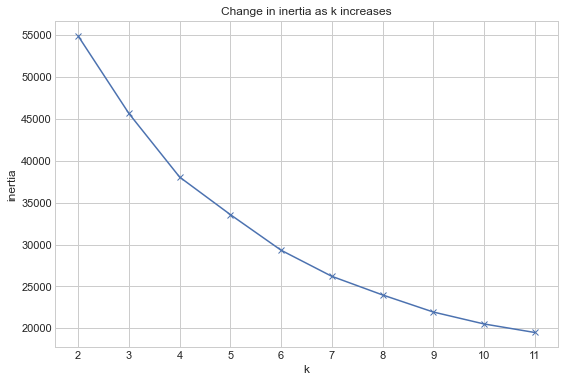

In [112]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

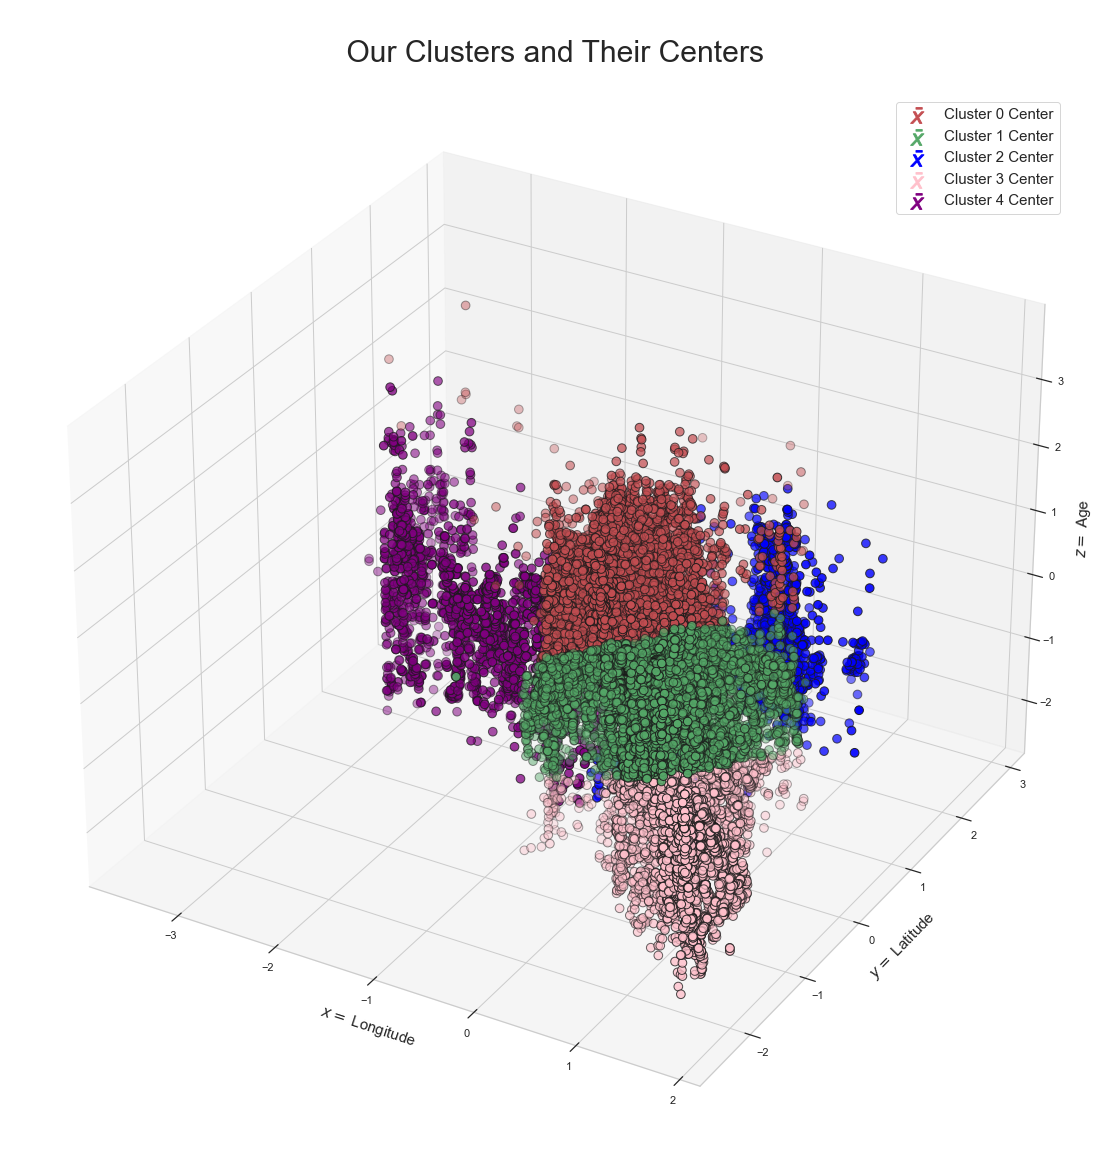

In [105]:

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# set x for each cluster
x0 = X_train_scaled[X_train_scaled['cluster'] == 0]['longitude']
x1 = X_train_scaled[X_train_scaled['cluster'] == 1]['longitude']
x2 = X_train_scaled[X_train_scaled['cluster'] == 2]['longitude']
x3 = X_train_scaled[X_train_scaled['cluster'] == 3]['longitude']
x4 = X_train_scaled[X_train_scaled['cluster'] == 4]['longitude']


# set y for each cluster
y0 = X_train_scaled[X_train_scaled['cluster'] == 0]['latitude']
y1 = X_train_scaled[X_train_scaled['cluster'] == 1]['latitude']
y2 = X_train_scaled[X_train_scaled['cluster'] == 2]['latitude']
y3 = X_train_scaled[X_train_scaled['cluster'] == 3]['latitude']
y4 = X_train_scaled[X_train_scaled['cluster'] == 4]['latitude']

# set z for each cluster
z0 = X_train_scaled[X_train_scaled['cluster'] == 0]['age']
z1 = X_train_scaled[X_train_scaled['cluster'] == 1]['age']
z2 = X_train_scaled[X_train_scaled['cluster'] == 2]['age']
z3 = X_train_scaled[X_train_scaled['cluster'] == 3]['age']
z4 = X_train_scaled[X_train_scaled['cluster'] == 4]['age']

zero_center = centroids[centroids.index == 0]
one_center = centroids[centroids.index == 1]
two_center = centroids[centroids.index == 2]
three_center = centroids[centroids.index == 3]
four_center = centroids[centroids.index == 4]

# plot cluster 0 with center
ax.scatter(x0, y0, z0, s=75, c='r', edgecolor='k', marker='o')
ax.scatter(zero_center.longitude, zero_center.latitude, zero_center.age, s=250, c='r', marker='$\\bar{x}$', label='Cluster 0 Center')
# plot cluster 1 with center
ax.scatter(x1, y1, z1, s=75, c='g', edgecolor='k', marker='o')
ax.scatter(one_center.longitude, one_center.latitude, one_center.age, s=250, c='g', marker='$\\bar{x}$', label='Cluster 1 Center')
# plot cluster 2 with center
ax.scatter(x2, y2, z2, s=75, c='blue', edgecolor='k', marker='o')
ax.scatter(two_center.longitude, two_center.latitude, two_center.age, s=250, c='blue', marker='$\\bar{x}$', label='Cluster 2 Center')
#plot cluster 3 with center
ax.scatter(x3, y3, z3, s=75, c='pink', edgecolor='k', marker='o')
ax.scatter(three_center.longitude, three_center.latitude, three_center.age, s=250, c='pink', marker='$\\bar{x}$', label='Cluster 3 Center')
#plot cluster 4 with center
ax.scatter(x4, y4, z4, s=75, c='purple', edgecolor='k', marker='o')
ax.scatter(four_center.longitude, four_center.latitude, four_center.age, s=250, c='purple', marker='$\\bar{x}$', label='Cluster 4 Center')

# set labels and title
ax.set_xlabel('\n$x =$ Longitude', fontsize=15)
ax.set_ylabel('\n$y =$ Latitude', fontsize=15)
ax.set_zlabel('\n$z =$ Age', fontsize=15)
plt.title('\n Our Clusters and Their Centers', fontsize=30)
plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)
plt.show()



In [118]:
#SELECT K BEST
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [119]:
f_feature

['tax_amount',
 'structure_dollar_per_sqft',
 'structure_dollar_sqft_bin',
 'lot_dollar_sqft_bin']

In [115]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 2)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [116]:
rfe_feature

['beds', 'bathsandbeds']

In [143]:
# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

Var  Rank
20       landtaxvaluedollarcnt     1
39                      orange     1
38                 los_angeles     1
37                        cola     1
32   structure_dollar_per_sqft     1
25                     Ventura     1
24                      Orange     1
23                          LA     1
22         censustractandblock     1
21                  tax_amount     1
40                     ventura     1
18                   tax_value     1
17  structuretaxvaluedollarcnt     1
41                bathsandbeds     1
3                        baths     1
12      rawcensustractandblock     1
4                         beds     1
5            calculatedbathnbr     1
28                     taxrate     2
8                  fullbathcnt     3
31                    sqft_bin     4
6                         sqft     5
7         finishedsquarefeet12     6
34        land_dollar_per_sqft     7
35         lot_dollar_sqft_bin     8
29                       acres     9
13                regionidcity    10
36              bath_bed_ratio    11
27                     age_bin    12
16                  year_built    13
14                 regionidzip    14
10                   longitude    15
9                     latitude    16
30                   acres_bin    17
26                         age    18
33   structure_dollar_sqft_bin    19
11           lotsizesquarefeet    20
15                     roomcnt    21
1                    parcel_id    22
0        propertylandusetypeid    23
2                           id    24
19              assessmentyear    25

In [124]:
X_train_scaled = X_train_scaled.drop(columns='cluster')

In [125]:
X_train_scaled

propertylandusetypeid  parcel_id        id     baths      beds  \
38772              -0.032276  -0.685718 -1.155051  0.996206  0.868302   
6386               -0.032276   0.452227  0.245436 -1.431686  2.013324   
36392              -0.032276   0.518165  0.800013 -0.217740  0.868302   
2872               -0.032276   0.619141  0.541452  0.389233  0.868302   
45193              -0.032276  -0.863285 -1.047275 -0.217740 -0.276720   
...                      ...        ...       ...       ...       ...   
58249              -0.032276  -0.108344  1.246804  0.996206  0.868302   
10491              -0.032276  -0.079638  0.329623 -1.431686 -0.276720   
54469              -0.032276   0.427568  1.318415 -0.217740 -0.276720   
74787              -0.032276  -0.293249 -0.400903 -1.431686 -0.276720   
5827               -0.032276   1.806494 -0.529502  0.389233 -0.276720   

       calculatedbathnbr      sqft  finishedsquarefeet12  fullbathcnt  \
38772           0.996306  1.537375              1.538834     1.086055   
6386           -1.431723 -0.473773             -0.477393    -1.383285   
36392          -0.217709  0.533240              0.532163    -0.148615   
2872            0.389299  1.025237              1.025403    -0.148615   
45193          -0.217709 -0.476651             -0.480278    -0.148615   
...                  ...       ...                   ...          ...   
58249           0.996306  2.699756              2.704150     1.086055   
10491          -1.431723 -1.054964             -1.060051    -1.383285   
54469          -0.217709 -0.581668             -0.585560    -0.148615   
74787          -1.431723 -1.172928             -1.178313    -1.383285   
5827            0.389299 -0.016302             -0.018766    -0.148615   

       latitude  ...  structure_dollar_per_sqft  structure_dollar_sqft_bin  \
38772  1.594207  ...                   0.294510                   0.905188   
6386  -0.721164  ...                  -1.002328                  -1.208471   
36392 -0.455192  ...                  -0.968817                  -1.208471   
2872  -1.578564  ...                  -0.381934                  -0.503918   
45193  0.357871  ...                   0.288102                   0.905188   
...         ...  ...                        ...                        ...   
58249 -0.873587  ...                   0.257163                   0.905188   
10491 -0.453077  ...                   0.816438                   0.905188   
54469 -0.816118  ...                  -0.234909                  -0.503918   
74787 -0.423524  ...                  -0.800836                  -1.208471   
5827   0.772148  ...                   0.475949                   0.905188   

       land_dollar_per_sqft  lot_dollar_sqft_bin  bath_bed_ratio      cola  \
38772             -0.284933             0.099635        0.305970 -0.527322   
6386              -0.416846            -0.682529       -2.163697 -0.527322   
36392             -0.645356            -1.464692       -0.816606 -0.527322   
2872               0.219649             0.881798       -0.255318 -0.527322   
45193             -0.478642            -0.682529       -0.068222  1.896373   
...                     ...                  ...             ...       ...   
58249              0.424382             0.881798        0.305970 -0.527322   
10491             -0.188984             0.099635       -1.564990 -0.527322   
54469             -0.029329             0.099635       -0.068222 -0.527322   
74787             -0.442236            -0.682529       -1.564990 -0.527322   
5827              -0.065122             0.099635        0.680162 -0.527322   

       los_angeles    orange   ventura  bathsandbeds  
38772     0.730536 -0.601758 -0.299127      1.038911  
6386     -1.368858  1.661797 -0.299127      0.380940  
36392    -1.368858  1.661797 -0.299127      0.380940  
2872     -1.368858  1.661797 -0.299127      0.709926  
45193     0.730536 -0.601758 -0.299127     -0.277030  
...            ...       ...       ...           

In [126]:
number_of_features_list=np.arange(1,40)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 18
Score with 18 features: 0.003787


In [127]:
cols = list(X_train_scaled.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 18)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['baths', 'beds', 'calculatedbathnbr', 'rawcensustractandblock',
       'structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt',
       'tax_amount', 'censustractandblock', 'LA', 'Orange', 'Ventura',
       'structure_dollar_per_sqft', 'cola', 'los_angeles', 'orange', 'ventura',
       'bathsandbeds'],
      dtype='object')


In [206]:
from sklearn.metrics import mean_squared_error, r2_score
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

#logerror_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

#RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')

#RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')
r2_baseline = r2_score(y_validate.logerror, y_validate.logerror_pred_mean)
print(f'The r^2 score for baseline is {round(r2_baseline,3)}')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  0.1688 
Validate/Out-of-Sample:  0.1632
----------------------------------
RMSE using Median
Train/In-Sample:  0.1691 
Validate/Out-of-Sample:  0.1635
----------------------------------
The r^2 score for baseline is -0.0


In [207]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

In [208]:
selected_features = ['bathsandbeds', 'tax_value',
       'tax_amount', 'rawcensustractandblock',
       'structure_dollar_per_sqft', 'los_angeles', 'orange', 'ventura']
#Our first model: LinearRegression
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

#predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm = r2_score(y_validate.logerror, y_validate.logerror_pred_lm)
print(f'The r^2 value for linear regression is {round(r2_score_lm,3)}')

RMSE for OLS using LinearRegression:
Training/In-Sample:  0.16851377542865506 
Validation/Out-of-Sample:  0.16301711369337507
The r^2 value for linear regression is 0.002


In [209]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)

In [210]:
selected_features = ['bathsandbeds', 'tax_value',
       'tax_amount', 'rawcensustractandblock',
       'structure_dollar_per_sqft', 'los_angeles', 'orange', 'ventura']
#LassoLars
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

#predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for OLS using LassoLars:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lars = r2_score(y_validate.logerror, y_validate.logerror_pred_lars)
print(f'The r^2 value for LassoLars regression is {round(r2_score_lars,3)}')

RMSE for OLS using LassoLars:
Training/In-Sample:  0.16880204139702645 
Validation/Out-of-Sample:  0.16321483314718824
The r^2 value for LassoLars regression is -0.0


In [211]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha = 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)

In [212]:
#TweedieRegressor
#create model object
glm = TweedieRegressor(power = 0,alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

#predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_glm = r2_score(y_validate.logerror, y_validate.logerror_pred_glm)
print(f'The r^2 value for TweedieRegressor regression is {round(r2_score_glm,3)}')

RMSE for OLS using TweedieRegressor:
Training/In-Sample:  0.16857531068732862 
Validation/Out-of-Sample:  0.16302216245818624
The r^2 value for TweedieRegressor regression is 0.002


In [213]:
metric_df = metric_df.append(
    {
    'model': 'GLM Model power 0',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_glm)}, ignore_index=True)

In [214]:
from sklearn.preprocessing import PolynomialFeatures

#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[selected_features])
X_test_degree2 = pf.transform(X_test_scaled[selected_features])

#linear regresson with 2 degrees
lm2 = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm2.fit(X_train_degree2,y_train.logerror)

#predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

#predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for OLS using Polynomial Regression (2 degrees):\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm2 = r2_score(y_validate.logerror, y_validate.logerror_pred_lm2)
print(f'The r^2 value for Polynomial Regression (2 degrees) is {round(r2_score_lm2,3)}')

RMSE for OLS using Polynomial Regression (2 degrees):
Training/In-Sample:  0.16830291516426713 
Validation/Out-of-Sample:  0.16309287864125754
The r^2 value for Polynomial Regression (2 degrees) is 0.001


In [215]:
metric_df = metric_df.append(
    {
    'model': 'Cubic Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm2)}, ignore_index=True)

In [216]:
metric_df

model  rmse_validate  r^2_validate
0        mean_baseline       0.163499      0.000000
1             OLS lm 1       0.163017      0.002421
2  LassoLars alpha = 1       0.163215      0.000000
3    GLM Model power 0       0.163022      0.002359
4          Cubic Model       0.163093      0.001517

Text(0.5, 1.0, 'Residuals')

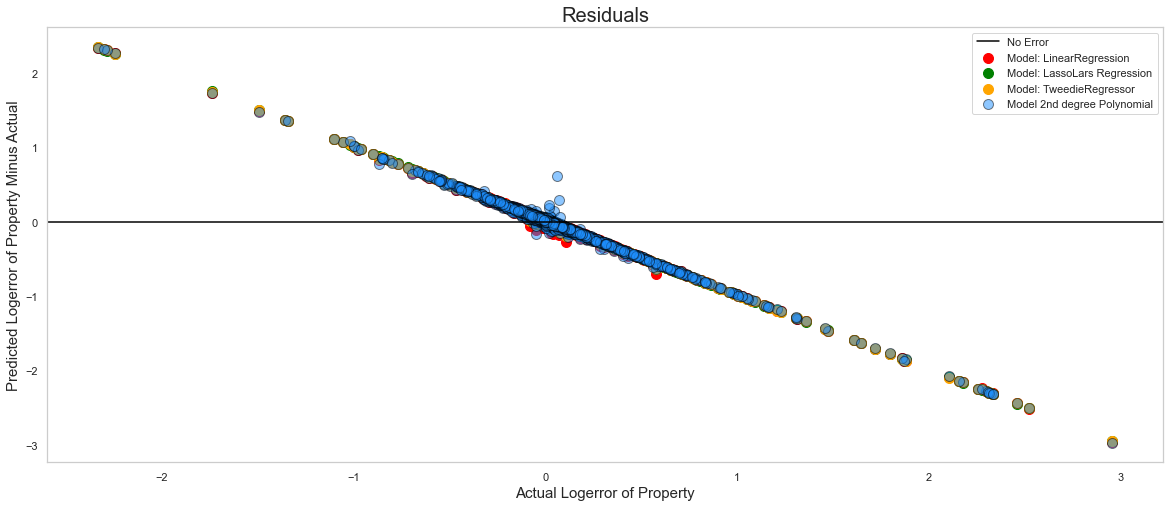

In [223]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm-y_validate.logerror, 
            alpha=1, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars-y_validate.logerror, 
            alpha=1, color="green", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm-y_validate.logerror, 
            alpha=1, color="orange", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2-y_validate.logerror, 
            alpha=.5, color="dodgerblue", s=100, edgecolors='black', label="Model 2nd degree Polynomial")
plt.legend()

plt.xlabel("Actual Logerror of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Logerror of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})

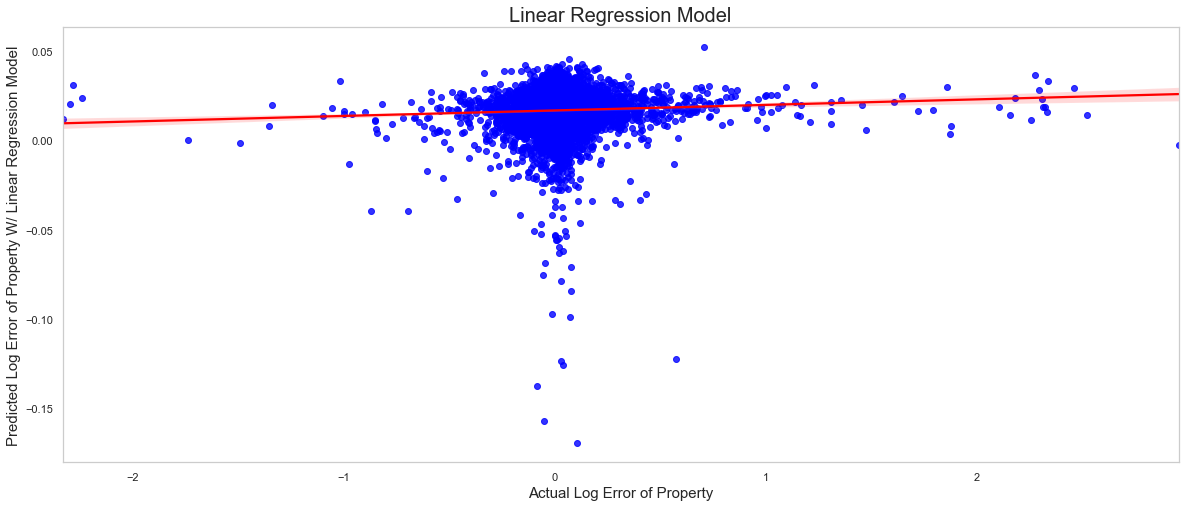

In [228]:
#looks like 3rd degree polynomial did the best, let's visualize that
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.logerror, y=y_validate.logerror_pred_lm, 
            scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel("Actual Log Error of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Log Error of Property W/ Linear Regression Model", fontdict={'fontsize':15})
plt.title("Linear Regression Model", fontdict={'fontsize': 20})

plt.show()

In [235]:
#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled[selected_features])

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print("RMSE for OLS Linear Regression Model \nOut-of-Sample Performance: ", rmse_test)
r2_test_score_lm = r2_score(y_test.logerror, y_test.logerror_pred_lm)
print(f'OLS Linear Regression has an R^2 value of {round(r2_test_score_lm,3)}')

             
             Our Test Model
----------------------------------
----------------------------------
RMSE for OLS Linear Regression Model 
Out-of-Sample Performance:  0.177365617264155
OLS Linear Regression has an R^2 value of 0.003
